In [3]:
from sdtw_div.numba_ops import *

In [4]:
from aeon.datasets import load_classification
X_te, y_te, meta_data = load_classification("ItalyPowerDemand", split="test", return_metadata=True, extract_path='/Data/aeon')
X_tr, y_tr, _ = load_classification("ItalyPowerDemand", split="train", return_metadata=True, extract_path='/Data/aeon')

In [5]:
X_tr[0].shape, X_tr.shape

((1, 24), (67, 1, 24))

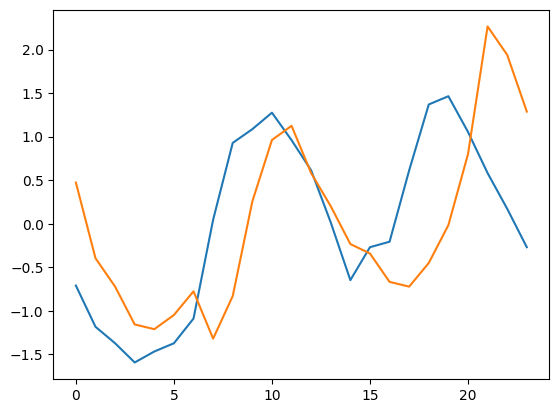

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(X_tr[0].ravel())
plt.plot(X_te[0].ravel())
plt.show()

In [7]:
n = 10
rng = np.random.default_rng(42)
classes = np.unique(y_tr)
k = rng.integers(0, len(classes))
X_a = X_tr[y_tr == classes[k]]

In [8]:
X_aa = X_a[rng.permutation(X_a.shape[0])[:n]]

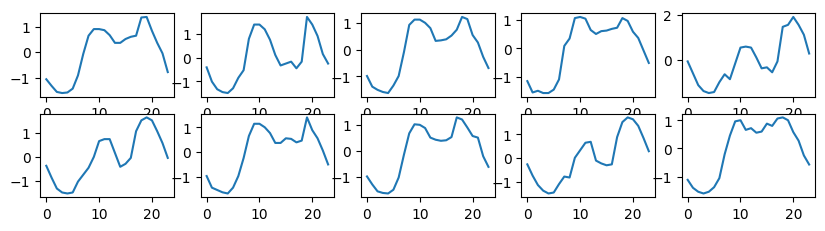

In [9]:
fig = plt.figure(figsize=(10, 5))
for i in range(n):
    ax = fig.add_subplot(4, 5, i + 1)
    ax.plot(X_aa[i].ravel())
plt.show()

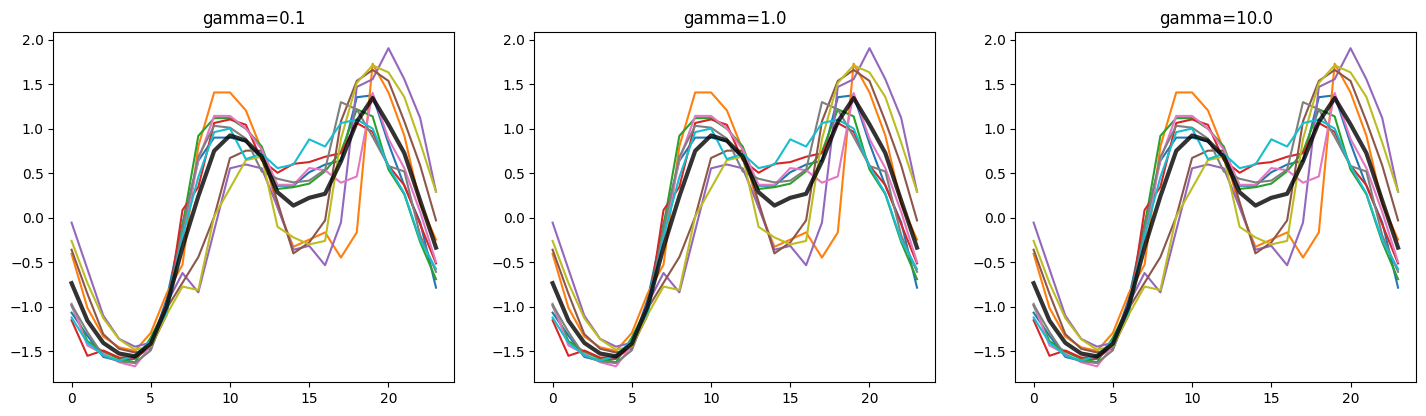

In [10]:
fig = plt.figure(figsize=(30, 10))
for i, gamma in enumerate([0.1, 1.0, 10.0]):
    ax = fig.add_subplot(2, 5, i + 1)
    for x in X_aa:
        ax.plot(x.ravel())
    value_and_grad = lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    Z = barycenter(X_aa, X_init="euclidean_mean", value_and_grad=value_and_grad, weights=None)
    ax.plot(Z.ravel(), color='k', linewidth=3, alpha=0.8)
    ax.set_title(f"gamma={gamma}")

plt.show()

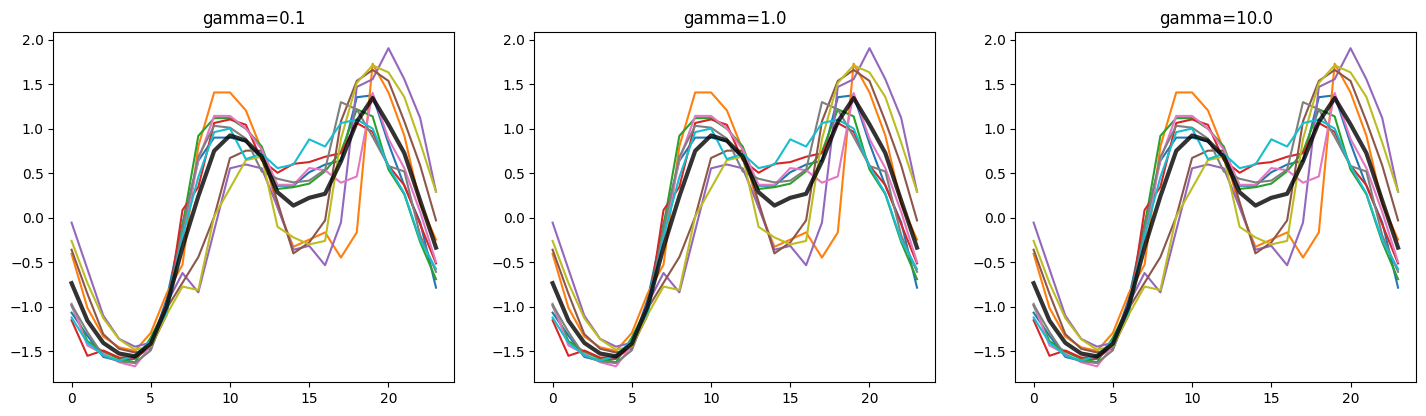

In [11]:
fig = plt.figure(figsize=(30, 10))
for i, gamma in enumerate([0.1, 1.0, 10.0]):
    ax = fig.add_subplot(2, 5, i + 1)
    for x in X_aa:
        ax.plot(x.ravel())
    value_and_grad = lambda X, Y: mean_cost_value_and_grad(X, Y) #, gamma=gamma)
    Z = barycenter(X_aa, X_init="euclidean_mean", value_and_grad=value_and_grad, weights=None)
    ax.plot(Z.ravel(), color='k', linewidth=3, alpha=0.8)
    ax.set_title(f"gamma={gamma}")

plt.show()

In [12]:
def load_ucr(dataset_name):
    # try:
    #     from tslearn.datasets import UCR_UEA_datasets
    #     ucr = UCR_UEA_datasets()
    #     X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)
    # # tslearn returns 3D arrays (n_ts, sz, dim). We ensure dim=1 or keep as-is.
    #     return X_train, y_train, X_test, y_test
    # except Exception as e:
    #     raise RuntimeError('tslearn UCR loader failed. Please install tslearn (pip install tslearn). Error: ' + str(e))
    X_te, y_te, meta_data = load_classification(dataset_name, split="test", return_metadata=True, extract_path='/Data/aeon')
    X_tr, y_tr, _ = load_classification(dataset_name, split="train", return_metadata=True, extract_path='/Data/aeon')
    return X_tr, y_tr, X_te, y_te



In [13]:

# --------------------------
# plotting utilities
# --------------------------

def plot_series_list(series_list, labels=None, title=None, filename=None):
    """Plot multiple time series on one axis.

    The previous version dynamically increased the figure height based on the
    number of series, which could create extremely tall images. We keep a
    fixed figure size and just overlay the curves.
    """

    plt.figure(figsize=(9, 4))

    for i, s in enumerate(series_list):
        if hasattr(s, "ndim") and s.ndim == 2 and s.shape[1] == 1:
            s = s[:, 0]
        plt.plot(s, label=(labels[i] if labels else None), linewidth=1.2)

    if labels:
        plt.legend(loc="best")

    if title:
        plt.title(title)

    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=150, bbox_inches="tight")
        plt.close()
    else:
        plt.show()


# --------------------------
# Experiment routines
# --------------------------

def experiment_average_10(dataset_name='UWaveGestureLibraryY', seed=0, divergence='sdtw_div', gamma=1.0):
    np.random.seed(seed)
    X_train, y_train, X_test, y_test = load_ucr(dataset_name)
    # pick k random series from train
    k=10
    n = len(X_train)
    idx = np.random.choice(n, size=min(k, n), replace=False)
    Ys = [X_train[i] for i in idx]
    # initial guess: euclidean mean
    X_init = euclidean_mean(Ys)
    if divergence == 'sdtw_div':
        valgrad = lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma)
    elif divergence == 'mean_cost':
        valgrad = mean_cost_div_value_and_grad
    else:
        valgrad = lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    print('Computing barycenter')
    Xbar = barycenter(Ys, X_init=X_init, value_and_grad=valgrad, weights=None, method='L-BFGS-B', tol=1e-3, max_iter=200)
    plot_series_list([Xbar] + Ys, labels=['barycenter'] + ['Y%d' % i for i in range(len(Ys))],
                     title=f'Average of 10 series on {dataset_name}', filename=f'{dataset_name}_avg10.png')
    print('Saved plot to', f'{dataset_name}_avg10.png')
    return Xbar


def experiment_interpolation(dataset_name='ArrowHead', idx1=0, idx2=1, pis=(0.25, 0.5, 0.75), gamma=10.0):
    X_train, y_train, X_test, y_test = load_ucr(dataset_name)
    Y1 = X_train[idx1]
    Y2 = X_train[idx2]
    results = []
    for pi in pis:
        Ys = [Y1, Y2]
        weights = np.array([pi, 1.0 - pi])
        X_init = euclidean_mean(Ys, weights=weights)
        valgrad = lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma)
        Xbar = barycenter(Ys, X_init=X_init, value_and_grad=valgrad, weights=weights, method='L-BFGS-B', tol=1e-3, max_iter=200)
        results.append((pi, Xbar))
    # Save plot
    series = [Y1, Y2] + [x for _, x in results]
    labels = ['Y1 (red)', 'Y2 (dark green)'] + [f'pi={pi}' for pi, _ in results]
    plot_series_list(series, labels=labels, title=f'Interpolation on {dataset_name}', filename=f'{dataset_name}_interp.png')
    print('Saved interpolation plot to', f'{dataset_name}_interp.png')
    return results


def experiment_barycenter_CBF(gamma=10.0):
    return experiment_average_10(dataset_name='CBF', divergence='sdtw_div', gamma=gamma)

# # --------------------------
# # Simple classification experiment (small-scale)
# # --------------------------

# def compute_divergence_matrix(Xs, fun, gamma=1.0):
#     n = len(Xs)
#     D = np.zeros((n, n))
#     for i in range(n):
#         for j in range(n):
#             D[i, j] = fun(Xs[i], Xs[j], gamma=gamma) if fun.__name__ == 'sdtw_div' else fun(Xs[i], Xs[j])
#     return D




In [ ]:

try:
    Xbar = experiment_average_10(dataset_name='UWaveGestureLibraryY', seed=1, divergence='sdtw_div', gamma=1.0)
except Exception as e:
    print('Error running average experiment:', e)   


Computing barycenter


/tmp/ipykernel_1458859/1972139925.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Error running average experiment: Image size of 1121x105471 pixels is too large. It must be less than 2^16 in each direction.


ValueError: Image size of 747x72625 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 900x400 with 1 Axes>

In [61]:
X.shape

(67, 1, 24)

In [15]:

def load_data(dataset_name):
    # try:
    #     from tslearn.datasets import UCR_UEA_datasets
    #     ucr = UCR_UEA_datasets()
    #     X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)
    # # tslearn returns 3D arrays (n_ts, sz, dim). We ensure dim=1 or keep as-is.
    #     return X_train, y_train, X_test, y_test
    # except Exception as e:
    #     raise RuntimeError('tslearn UCR loader failed. Please install tslearn (pip install tslearn). Error: ' + str(e))
    # X_te, y_te, meta_data = load_classification(dataset_name, split="test", return_metadata=True, extract_path='/Data/aeon')
    X_tr, y_tr, _ = load_classification(dataset_name, split="train", return_metadata=True, extract_path='/Data/aeon')
    return X_tr, y_tr #, X_te, y_te


def plot_barycenters(dataset_name, n_samples=10, gamma=10.0):
    print(f"\nRunning Averaging Experiment on {dataset_name}...")
    X_all, y_all = load_data(dataset_name)
    if X_all is None: return

    # Pick random samples (fixed seed for reproducibility)
    np.random.seed(42)
    indices = np.random.choice(len(X_all), n_samples, replace=False)
    Ys = [X_all[i].T for i in indices] # the data have shape (1, T) so i make it T x 1

    # Initialize results dictionary
    results = {}

    # 1. Euclidean Mean
    print("Computing Euclidean Mean...")
    results['Euclidean mean'] = euclidean_mean(Ys)

    # 2. Soft-DTW (Biased)
    # Init with Euclidean
    print(f"Computing Soft-DTW (gamma={gamma})...")
    results['SDTW'] = barycenter(
        Ys, X_init=results['Euclidean mean'], 
        value_and_grad=functools.partial(sdtw_value_and_grad, gamma=gamma)
    )

    # 3. Soft-DTW Divergence (Unbiased)
    # Init with SDTW result
    print(f"Computing SDTW Divergence (gamma={gamma})...")
    results['SDTW divergence'] = barycenter(
        Ys, X_init=results['SDTW'], 
        value_and_grad=functools.partial(sdtw_div_value_and_grad, gamma=gamma)
    )

    # 4. Sharp SDTW (Biased)
    print(f"Computing Sharp SDTW (gamma={gamma})...")
    results['Sharp SDTW'] = barycenter(
        Ys, X_init=results['Euclidean mean'], 
        value_and_grad=functools.partial(sharp_sdtw_value_and_grad, gamma=gamma)
    )

    # 5. Sharp Divergence (Unbiased)
    # Init with Sharp SDTW result
    print(f"Computing Sharp Divergence (gamma={gamma})...")
    results['Sharp divergence'] = barycenter(
        Ys, X_init=results['Sharp SDTW'], 
        value_and_grad=functools.partial(sharp_sdtw_div_value_and_grad, gamma=gamma)
    )

    # 6. Mean Cost (Biased)
    print("Computing Mean Cost...")
    results['Mean cost'] = barycenter(
        Ys, X_init=results['Euclidean mean'], 
        value_and_grad=mean_cost_value_and_grad
    )

    # 7. Mean Cost Divergence (Unbiased)
    # Init with Mean Cost result
    print("Computing Mean Cost Divergence...")
    results['Mean-cost divergence'] = barycenter(
        Ys, X_init=results['Mean cost'], 
        value_and_grad=mean_cost_div_value_and_grad
    )
    
    # 8. Approximation of DTW using small gamma SDTW
    print("Computing DTW approximation (SDTW gamma=0.1)...")
    results['DTW'] = barycenter(
        Ys, X_init=results['Euclidean mean'],
        value_and_grad=functools.partial(sdtw_value_and_grad, gamma=0.1)
    )

    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"Barycenters on {dataset_name}", fontsize=16)
    axes = axes.ravel()
    
    order = ['Euclidean mean', 'SDTW', 'Sharp SDTW', 'Mean cost',
             'DTW', 'SDTW divergence', 'Sharp divergence', 'Mean-cost divergence']

    for ax, name in zip(axes, order):
        # Plot background samples
        for Y in Ys:
            ax.plot(Y, color='k', alpha=0.1)
        
        # Plot barycenter
        # Colors mimicking the paper roughly
        color = 'tab:blue'
        if 'DTW' in name and 'Soft' not in name: color = 'orange'
        if 'SDTW' in name: color = 'tab:green'
        if 'SDTW divergence' in name: color = 'tab:red'
        if 'Sharp' in name: color = 'tab:purple'
        if 'Sharp divergence' in name: color = 'brown'
        if 'Mean' in name: color = 'tab:pink'
        if 'Mean-cost divergence' in name: color = 'tab:gray'

        # For the plot we need to flatten the (T, 1) array to (T,)
        ax.plot(results[name].ravel(), color=color, linewidth=2)
        ax.set_title(name)
        ax.set_ylim(results[name].min() - 1, results[name].max() + 1)
        
    plt.tight_layout()
    plt.show()

def plot_interpolation(dataset_name, gamma=1.0):
    print(f"\nRunning Interpolation Experiment on {dataset_name}...")
    X_all, y_all = load_data(dataset_name)
    if X_all is None: return

    # Pick two distinct time series
    np.random.seed(10) 
    # Trying to pick two that look different for better viz
    idx1, idx2 = 0, 1
    Y1 = X_all[idx1].T
    Y2 = X_all[idx2].T
    Ys = [Y1, Y2]

    weights_list = [
        [0.75, 0.25], # Closer to Y1
        [0.50, 0.50], # Middle
        [0.25, 0.75]  # Closer to Y2
    ]

    methods = {
        'Euclidean mean': (None, None),
        'SDTW': (functools.partial(sdtw_value_and_grad, gamma=gamma), 'Euclidean mean'),
        'Sharp SDTW': (functools.partial(sharp_sdtw_value_and_grad, gamma=gamma), 'Euclidean mean'),
        'Mean cost': (mean_cost_value_and_grad, 'Euclidean mean'),
        'DTW': (functools.partial(sdtw_value_and_grad, gamma=0.1), 'Euclidean mean'),
        'SDTW divergence': (functools.partial(sdtw_div_value_and_grad, gamma=gamma), 'SDTW'),
        'Sharp divergence': (functools.partial(sharp_sdtw_div_value_and_grad, gamma=gamma), 'Sharp SDTW'),
        'Mean-cost divergence': (mean_cost_div_value_and_grad, 'Mean cost')
    }

    # Pre-compute unbiased inits (biased counterparts)
    cache = {}
    
    # Prepare Plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"Interpolation on {dataset_name}", fontsize=16)
    axes = axes.ravel()
    
    order = ['Euclidean mean', 'SDTW', 'Sharp SDTW', 'Mean cost',
             'DTW', 'SDTW divergence', 'Sharp divergence', 'Mean-cost divergence']

    for ax, name in zip(axes, order):
        func, init_key = methods[name]
        
        # Plot Source and Target
        ax.plot(Y1.ravel(), color='red', alpha=0.3, label='Y1')
        ax.plot(Y2.ravel(), color='darkgreen', alpha=0.3, label='Y2')

        for w in weights_list:
            # Determine Initialization
            X_init = None
            if name == 'Euclidean mean':
                res = euclidean_mean(Ys, weights=w)
            else:
                # Need init
                if init_key == 'Euclidean mean':
                    X_init = euclidean_mean(Ys, weights=w)
                else:
                    # For divergences, use the cached result of the biased version with these weights
                    # Key for cache needs to include weights
                    cache_key = f"{init_key}_{w[0]}"
                    if cache_key in cache:
                        X_init = cache[cache_key]
                    else:
                        # Fallback if execution order is messed up (shouldn't happen with this list)
                        X_init = euclidean_mean(Ys, weights=w)

                res = barycenter(Ys, X_init=X_init, value_and_grad=func, weights=w)
            
            # Cache result for divergence initialization
            cache_key = f"{name}_{w[0]}"
            cache[cache_key] = res
            
            # Color logic
            # Gradual shift from red to green
            color_interp = plt.cm.autumn(w[0]) # Map weight to colormap
            
            ax.plot(res.ravel(), color=color_interp, linewidth=2)

        ax.set_title(name)
    
    plt.tight_layout()
    plt.show()




Running Averaging Experiment on UWaveGestureLibraryY...
Computing Euclidean Mean...
Computing Soft-DTW (gamma=10.0)...
Computing SDTW Divergence (gamma=10.0)...
Computing Sharp SDTW (gamma=10.0)...
Computing Sharp Divergence (gamma=10.0)...
Computing Mean Cost...
Computing Mean Cost Divergence...
Computing DTW approximation (SDTW gamma=0.1)...


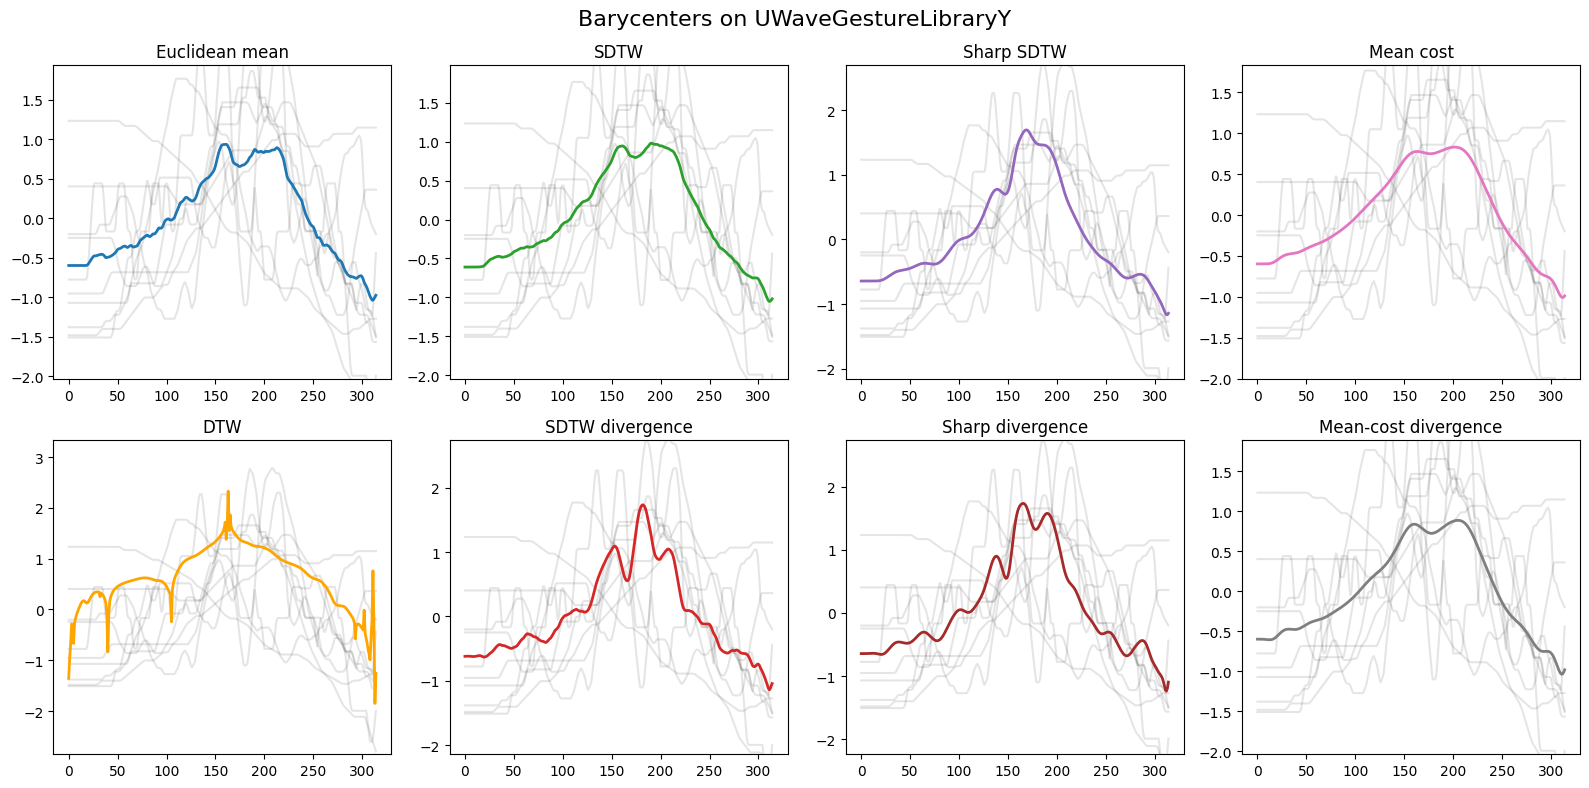

In [16]:

# Experiment 1: Barycenters on uWaveGestureLibrary_Y (Figure 3 in paper)
# The paper uses gamma=10 for uWave
plot_barycenters("UWaveGestureLibraryY", n_samples=10, gamma=10.0)



Running Averaging Experiment on CBF...
Computing Euclidean Mean...
Computing Soft-DTW (gamma=4)...
Computing SDTW Divergence (gamma=4)...
Computing Sharp SDTW (gamma=4)...
Computing Sharp Divergence (gamma=4)...
Computing Mean Cost...
Computing Mean Cost Divergence...
Computing DTW approximation (SDTW gamma=0.1)...


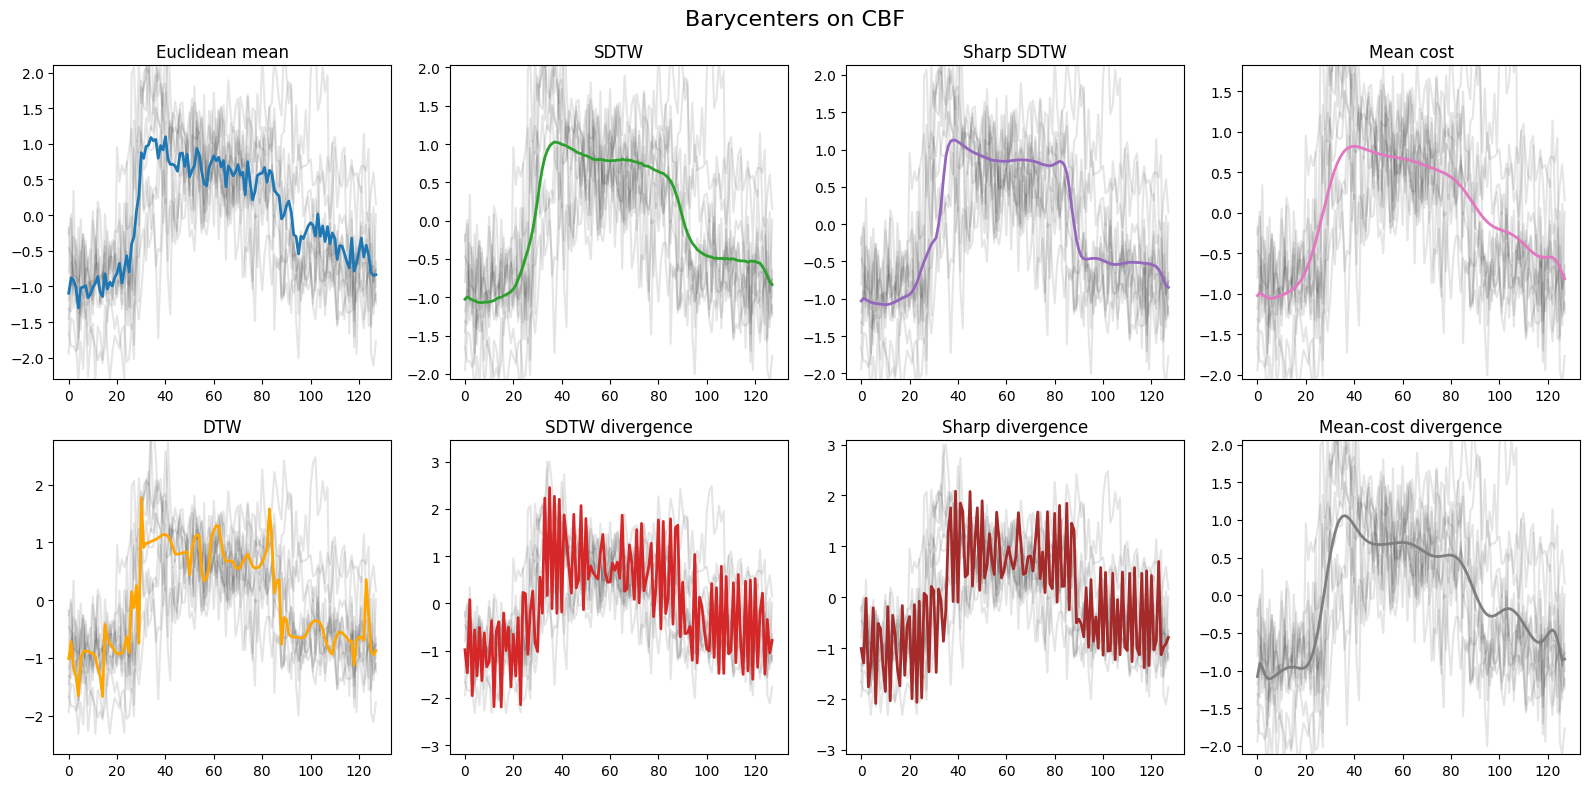

In [17]:

# Experiment 2: Barycenters on CBF (Additional example mentioned in text)
plot_barycenters("CBF", n_samples=10, gamma=4)



Running Interpolation Experiment on ArrowHead...


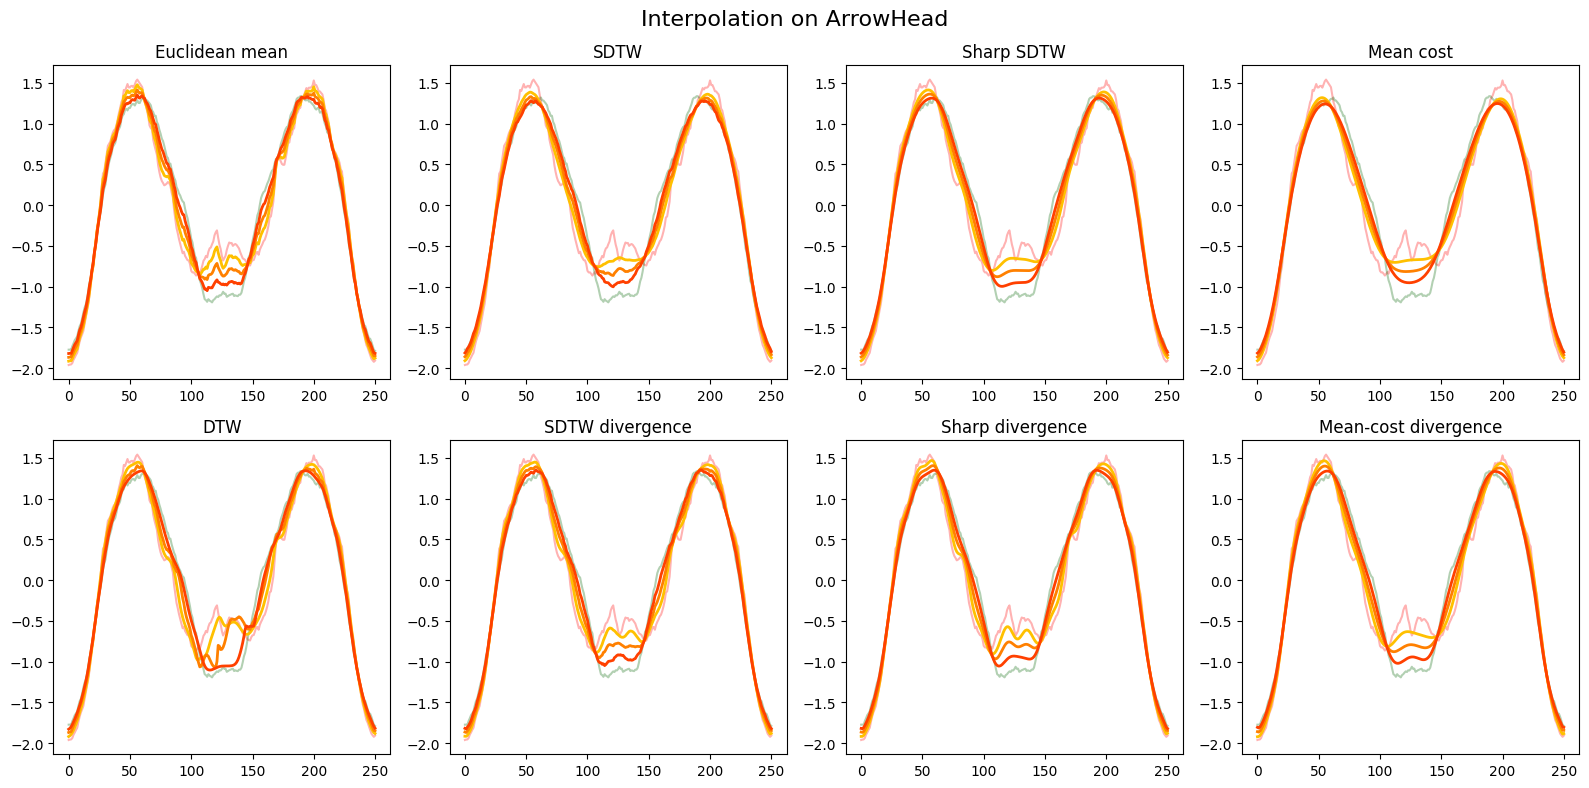

In [18]:

# Experiment 3: Interpolation on ArrowHead (Figure 4 in paper)
plot_interpolation("ArrowHead", gamma=10.0)

# New exps


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import functools
from aeon.datasets import load_classification


def experiment_gamma_barycenter_evolution(X_train, n_samples=10, gammas=[0.01, 1.0, 10.0, 100.0]):
    """
    Visualizes how the shape of the barycenter evolves as gamma increases.
    """
    print(f"\n--- Experiment 1: Barycenter Evolution (n={n_samples}) ---")
    
    # Select random subset
    np.random.seed(42)
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    Ys = [X_train[i].T for i in indices] # Shape (T, D)

    # 1. Compute Euclidean Mean (Limit as gamma -> infinity)
    euclidean_bar = euclidean_mean(Ys)

    fig, axes = plt.subplots(1, len(gammas) + 1, figsize=(20, 4), sharey=True)
    
    # Plot inputs in background
    for ax in axes:
        for y in Ys:
            ax.plot(y.ravel(), color='gray', alpha=0.1)
    
    # Iterate gammas
    for i, g in enumerate(gammas):
        print(f"Computing Soft-DTW Barycenter (gamma={g})...")
        
        # We use sdtw_div (Divergence) for the most mathematically robust centroid
        val_grad_fn = functools.partial(sdtw_div_value_and_grad, gamma=g)
        
        # Initialize with Euclidean mean for speed
        bary = barycenter(Ys, X_init=euclidean_bar, value_and_grad=val_grad_fn)
        
        axes[i].plot(bary.ravel(), 'r-', linewidth=2)
        axes[i].set_title(f"SDTW Div\n$\gamma={g}$")
        axes[i].grid(True, alpha=0.3)

    # Plot Euclidean Mean
    axes[-1].plot(euclidean_bar.ravel(), 'b-', linewidth=2)
    axes[-1].set_title("Euclidean Mean\n($\gamma \\to \infty$)")
    axes[-1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def experiment_gamma_variance_landscape(X_train, n_samples=5):
    """
    Analyzes the 'Fréchet Variance' (the minimized objective value) 
    as a function of gamma.
    """
    print(f"\n--- Experiment 2: Effect of Gamma on Fréchet Variance (n={n_samples}) ---")
    
    np.random.seed(42)
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    Ys = [X_train[i].T for i in indices]
    
    gammas = np.logspace(-2, 2, 15) # From 0.01 to 100
    variances = []
    
    euclidean_bar = euclidean_mean(Ys)

    for g in gammas:
        # Calculate barycenter for this gamma
        val_grad_fn = functools.partial(sdtw_div_value_and_grad, gamma=g)
        bary = barycenter(Ys, X_init=euclidean_bar, value_and_grad=val_grad_fn, max_iter=50)
        
        # Calculate the total variance (sum of divergences)
        total_variance = 0
        for y in Ys:
            div = sdtw_div(bary, y, gamma=g)
            total_variance += div
        
        variances.append(total_variance / n_samples)

    plt.figure(figsize=(8, 5))
    plt.plot(gammas, variances, 'o-', color='purple')
    plt.xscale('log')
    plt.xlabel(r"Regularization strength $\gamma$ (log scale)")
    plt.ylabel("Fréchet Variance (Mean SDTW Divergence)")
    plt.title("Effect of $\gamma$ on the Minimum Variance")
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()
    
    #  
    # This visualization helps understand convexity changes.

def experiment_gamma_alignment_sparsity(X_train):
    """
    Visualizes the alignment matrix (Gibbs distribution) to show how 
    entropy/sparsity changes with gamma.
    """
    print(f"\n--- Experiment 3: Alignment Sparsity vs Gamma ---")
    
    # Pick two distinct samples
    X = X_train[0].T
    Y = X_train[1].T
    
    gammas = [0.01, 0.1, 1.0, 10.0]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, g in enumerate(gammas):
        # Compute Cost Matrix
        C = squared_euclidean_cost(X, Y)
        
        # Get Probability Matrix P (Gradient of Soft-DTW w.r.t Cost)
        # Note: sdtw_grad_C returns the expected alignment E
        # We need to compute V, P first.
        V, P_tensor = sdtw_C(C, gamma=g, return_all=True)
        E = sdtw_grad_C(P_tensor)
        
        im = axes[i].imshow(E, origin='lower', cmap='viridis', vmin=0, vmax=1)
        axes[i].set_title(f"Alignment Matrix\n$\gamma={g}$")
        axes[i].axis('off')
        
    plt.suptitle("Evolution of Alignment Entropy (Sharp to Diffuse)")
    plt.tight_layout()
    plt.show()




--- Experiment 1: Barycenter Evolution (n=10) ---
Computing Soft-DTW Barycenter (gamma=0.01)...
Computing Soft-DTW Barycenter (gamma=1.0)...
Computing Soft-DTW Barycenter (gamma=10.0)...
Computing Soft-DTW Barycenter (gamma=100.0)...


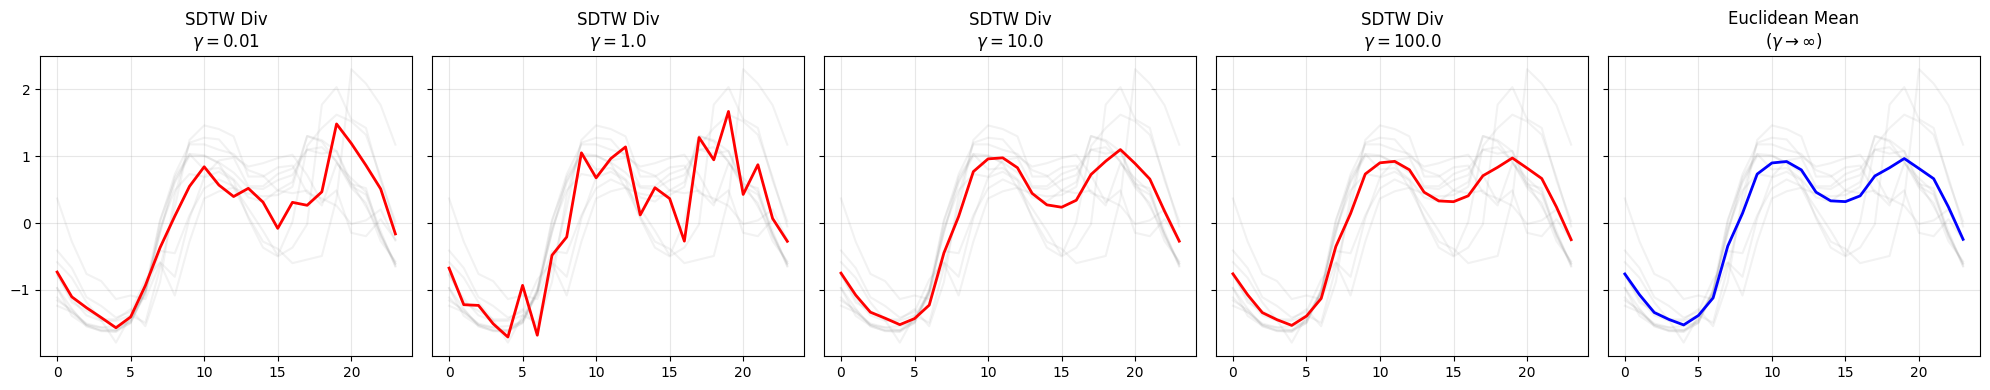


--- Experiment 2: Effect of Gamma on Fréchet Variance (n=5) ---


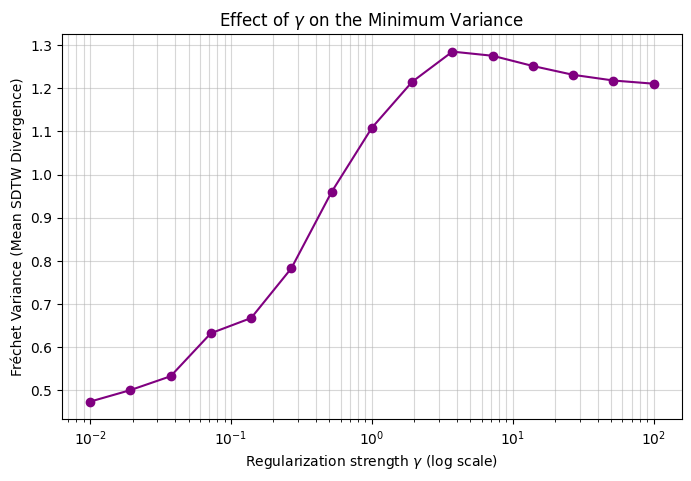


--- Experiment 3: Alignment Sparsity vs Gamma ---


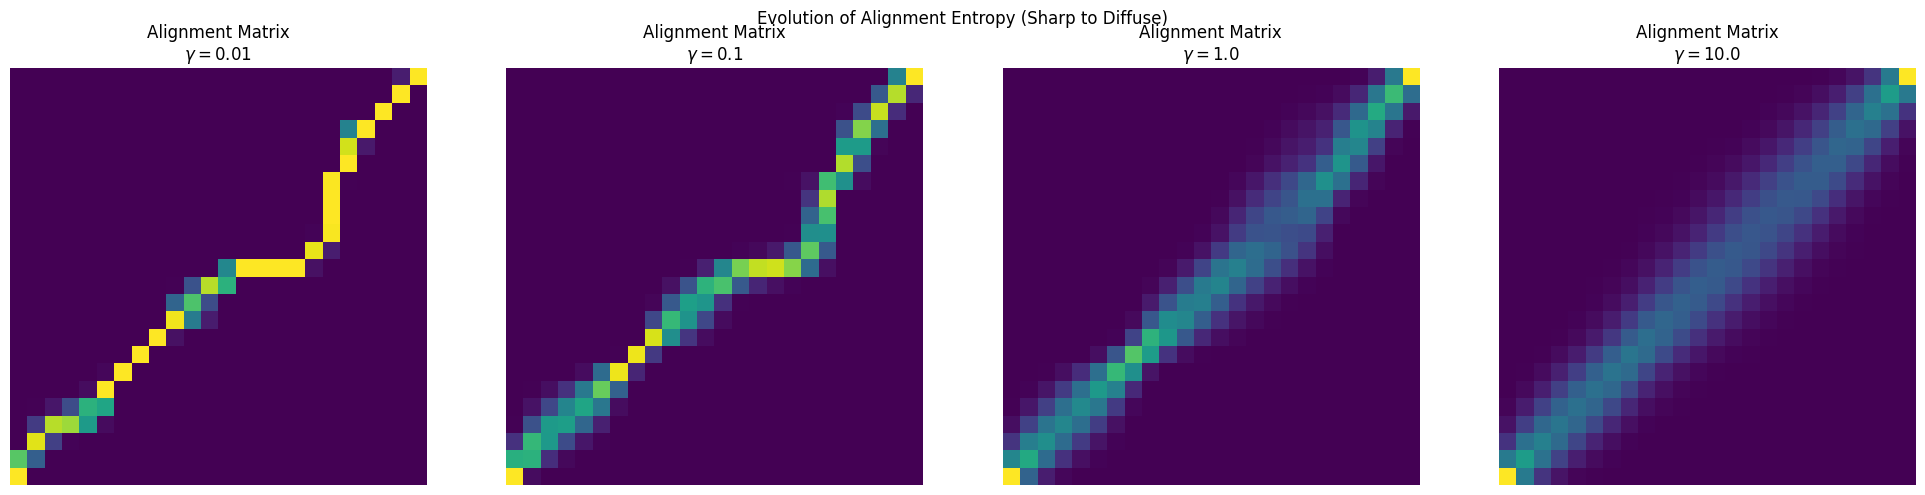

In [20]:

try:
    # Load dataset
    X_tr, y_tr, _ = load_classification("ItalyPowerDemand", split="train", return_metadata=True)
    
    # Experiment 1: Visual Evolution of the Barycenter
    experiment_gamma_barycenter_evolution(X_tr)
    
    # Experiment 2: Quantitative Variance
    experiment_gamma_variance_landscape(X_tr)
    
    # Experiment 3: Alignment Matrix Visualization
    experiment_gamma_alignment_sparsity(X_tr)
    
except Exception as e:
    print(f"Error running experiments: {e}")
    print("Ensure 'aeon' is installed or replace data loading with synthetic data.")

Here is the explanation of the three experiments designed to analyze the effect of the regularization parameter  (gamma) in the Soft-DTW framework.

### Overview: The Role of 

The Soft-DTW metric defines the distance between two time series  and  using a **soft minimum** over all possible alignment paths . The parameter  controls the smoothness of this minimum:

where  is the cost matrix (usually squared Euclidean distances).

* **As**: The soft-min converges to the hard minimum. The metric behaves like standard Dynamic Time Warping (DTW).
* **As**: The soft-min considers all paths equally. The metric converges toward a global alignment kernel, and the optimal centroid converges to the Euclidean mean.

---

### Experiment 1: Barycenter Evolution

**Objective:** To visualize how the shape of the representative time series (barycenter) changes as we increase smoothing.

The barycenter  is defined as the minimizer of the Fréchet variation (the sum of divergences):

**Expected Outcome:**

* **Low  (e.g., 0.01)**: The barycenter mimics the behavior of **Hard DTW**. It preserves sharp features, slopes, and local shapes because it aligns strictly to the features of the input samples. However, the optimization landscape may be non-smooth, potentially leading to local minima.
* **Medium  (e.g., 1.0)**: This offers a trade-off. The barycenter retains the overall shape but smooths out high-frequency noise. This is often the "sweet spot" for classification tasks.
* **High  (e.g., 100)**: As  grows, the alignment becomes "confused" (considering all points aligned to all points). The barycenter loses its temporal elasticity and collapses toward the **Euclidean Mean** (the arithmetic average of the points at each timestamp).

---

### Experiment 2: Fréchet Variance Landscape

**Objective:** To quantify the "compactness" of the dataset under the Soft-DTW geometry as a function of .

We compute the minimized objective value (the total variance) for the optimal barycenter:

**Expected Outcome:**

* This experiment plots  against  (on a log scale).
* **Scale Sensitivity**: Since the Soft-DTW formula involves scaling by , the absolute value of the loss changes.
* **Optimization Difficulty**: At very low , the variance might fluctuate or optimization might take longer due to the non-convex nature of the "hard" alignment landscape. At high , the curve smoothes out, indicating a convex, easy-to-optimize landscape (approaching the convex Euclidean objective).

---

### Experiment 3: Alignment Sparsity (Entropy)

**Objective:** To visualize the internal gradient (the alignment matrix) and observe the "entropy" of the coupling between time steps.

The alignment matrix  (computed by `sdtw_grad_C`) represents the expected alignment under the Gibbs distribution defined by . Each entry  corresponds to the probability that time step  in series  aligns with time step  in series :

**Expected Outcome:**

* **Low  (Sparse/Hard)**: The heatmap of  will look like a **thin, binary path** (mostly zeros, with ones along the optimal path). The entropy of the distribution is near zero.
* **High  (Diffuse/Soft)**: The heatmap will blur. A single point in  will align with a weighted window of points in . The entropy is high.
* **Interpretation**: This visualizes the "attention" of the metric. Low  focuses entirely on the best match; high  averages over a local neighborhood of matches.

# More

In [ ]:
"""
sdtw_gamma_experiments.py

Add-on experiments to explore the effect of gamma on soft-DTW barycenters.

Place this file in the same environment where the SDTW implementation (the big file you
shared) is available (same notebook or same python path). It re-uses functions such as
`sdtw_value_and_grad`, `sdtw_div_value_and_grad`, `euclidean_mean`, `barycenter`,
`sdtw`, and `sdtw_entropy` defined in that implementation.

Usage example (from a notebook or python REPL where the original functions are loaded):

    from sdtw_gamma_experiments import run_gamma_experiments
    run_gamma_experiments('CBF', n_samples=8)

This will compute barycenters for multiple gammas and plot several metrics showing
how barycenters evolve when gamma changes.

"""

import os
import time
import functools





def _ensure_list_of_Ys(X_all, indices):
    """Return Ys as list of (T, 1) arrays.
    X_all entries are expected to be shape (1, T) or (T, 1). We normalize to (T, D).
    """
    Ys = []
    for i in indices:
        x = X_all[i]
        # Convert to 2D (T, D) with D>=1
        arr = np.asarray(x)
        if arr.ndim == 1:
            arr = arr[:, np.newaxis]
        # many UCR loaders return (1, T) so transpose
        if arr.shape[0] == 1 and arr.shape[1] > 1:
            arr = arr.T
        Ys.append(arr)
    return Ys


def run_gamma_experiments(dataset_name,
                          n_samples=8,
                          gammas=None,
                          methods=('SDTW', 'SDTW_div'),
                          init_with_euclidean=True,
                          out_dir='./sdtw_gamma_results',
                          verbose=True):
    """Run experiments varying gamma and produce plots + metrics.

    Parameters
    ----------
    dataset_name : str
        Name of dataset accepted by your `load_data` function (UCR/aeon name used in your code).
    n_samples : int
        Number of random samples to average (barycenter inputs).
    gammas : list or None
        List of gamma values to try (default: logarithmic range).
    methods : tuple
        Which barycenter objectives to compute. Supported keys: 'SDTW', 'SDTW_div',
        'Sharp', 'Sharp_div', 'MeanCost'.
    init_with_euclidean : bool
        Use euclidean mean to initialize barycenters (recommended for stability).
    out_dir : str
        Directory where figures (and optional arrays) are saved.
    verbose : bool
        Print progress messages.

    Returns
    -------
    results : dict
        Nested dict: results[method][gamma] -> barycenter array (T, D)
    metrics : dict
        metrics[method] -> dict with arrays for each metric keyed by metric name
    """

    if gammas is None:
        gammas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

    os.makedirs(out_dir, exist_ok=True)

    # Load data
    if verbose: print(f"Loading dataset {dataset_name}...")
    try:
        X_all, y_all = load_data(dataset_name)
    except Exception as e:
        raise RuntimeError("Could not load dataset. Ensure load_data is available: " + str(e))

    # Select subset of time series
    rng = np.random.RandomState(42)
    indices = rng.choice(len(X_all), size=min(n_samples, len(X_all)), replace=False)
    Ys = _ensure_list_of_Ys(X_all, indices)

    # Prepare result containers
    results = {m: {} for m in methods}
    metrics = {m: {
        'var_scalar': [],       # global variance of barycenter
        'var_time': [],         # variance vector across timepoints (we'll store mean of that)
        'mean_sdtw': [],        # average sdtw value between barycenter and Ys (using same gamma)
        'mean_entropy': [],     # average sdtw entropy between barycenter and Ys
        'grad_norm': [],        # norm of aggregated gradient at final barycenter
        'shift_dist': []        # distance to previous gamma barycenter
    } for m in methods}

    # Precompute euclidean init
    if init_with_euclidean:
        if verbose: print("Computing Euclidean mean initialization...")
        X_init = euclidean_mean(Ys)
    else:
        X_init = Ys[0].copy()

    # Helper mapping from method name to value_and_grad callable
    def _get_vg(method, gamma):
        if method == 'SDTW':
            return functools.partial(sdtw_value_and_grad, gamma=gamma)
        if method == 'SDTW_div':
            return functools.partial(sdtw_div_value_and_grad, gamma=gamma)
        if method == 'Sharp':
            return functools.partial(sharp_sdtw_value_and_grad, gamma=gamma)
        if method == 'Sharp_div':
            return functools.partial(sharp_sdtw_div_value_and_grad, gamma=gamma)
        if method == 'MeanCost':
            return mean_cost_value_and_grad
        raise ValueError(f"Unknown method: {method}")

    # Main loop over gammas and methods
    for method in methods:
        prev_Z = None
        if verbose: print(f"\n=== Method: {method} ===")
        for gamma in gammas:
            if verbose: print(f"gamma={gamma}  -> computing barycenter...")
            start = time.time()

            vg = _get_vg(method, gamma)

            # Use the euclidean init or method-specific fallback
            X0 = X_init.copy()

            try:
                Z = barycenter(Ys, X_init=X0, value_and_grad=vg)
            except Exception as e:
                # Try a simpler fallback: L-BFGS with fewer iterations or smaller sample set
                print(f"barycenter failed for method={method}, gamma={gamma}: {e}")
                raise

            results[method][gamma] = Z
            elapsed = time.time() - start
            if verbose: print(f"  done in {elapsed:.1f}s; barycenter shape={Z.shape}")

            # Metrics
            # 1) variance of barycenter
            var_scalar = float(np.var(Z))
            var_time_mean = float(np.mean(np.var(Z, axis=0))) if Z.ndim == 2 else float(np.var(Z))

            # 2) mean sdtw distance to samples (use sdtw with same gamma if available)
            sdtw_vals = []
            ent_vals = []
            for Y in Ys:
                try:
                    sdtw_vals.append(float(sdtw(Z, Y, gamma=gamma)))
                except Exception:
                    # fallback: compute using gamma=1 if sdtw with gamma fails
                    sdtw_vals.append(float(sdtw(Z, Y)))
                try:
                    ent_vals.append(float(sdtw_entropy(Z, Y, gamma=gamma)))
                except Exception:
                    ent_vals.append(np.nan)

            mean_sdtw = float(np.nanmean(sdtw_vals))
            mean_entropy = float(np.nanmean(ent_vals))

            # 3) aggregated gradient norm at final barycenter
            G = np.zeros_like(Z)
            for Y in Ys:
                try:
                    _, g = vg(Z, Y)
                except Exception:
                    # If vg signature mismatches (some functions expect (C,gamma) variants), skip
                    g = np.zeros_like(Z)
                G += g
            grad_norm = float(np.linalg.norm(G))

            # 4) shift from previous gamma
            if prev_Z is None:
                shift_dist = 0.0
            else:
                shift_dist = float(np.linalg.norm(Z.ravel() - prev_Z.ravel()))

            prev_Z = Z.copy()

            # Store metrics
            metrics[method]['var_scalar'].append(var_scalar)
            metrics[method]['var_time'].append(var_time_mean)
            metrics[method]['mean_sdtw'].append(mean_sdtw)
            metrics[method]['mean_entropy'].append(mean_entropy)
            metrics[method]['grad_norm'].append(grad_norm)
            metrics[method]['shift_dist'].append(shift_dist)

            # Optionally save intermediate barycenters
            # np.savez_compressed(os.path.join(out_dir, f"bary_{dataset_name}_{method}_gamma{gamma}.npz"), Z=Z)

    # Plotting results
    if verbose: print('\nPlotting results...')

    # For each method create a figure with barycenters (top) and metric panels (bottom)
    for method in methods:
        fig = plt.figure(figsize=(14, 10))
        gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 0.8, 0.8])

        ax_bary = fig.add_subplot(gs[0, :])
        ax_var = fig.add_subplot(gs[1, 0])
        ax_entropy = fig.add_subplot(gs[1, 1])
        ax_grad = fig.add_subplot(gs[2, 0])
        ax_shift = fig.add_subplot(gs[2, 1])

        # Plot background samples
        for Y in Ys:
            ax_bary.plot(Y.ravel(), color='k', alpha=0.08)

        # Color mapping for gammas
        cmap = plt.get_cmap('viridis')
        norm_g = (np.array(gammas) - np.min(gammas)) / (np.max(gammas) - np.min(gammas) + 1e-12)

        for idx, gamma in enumerate(gammas):
            Z = results[method][gamma]
            ax_bary.plot(Z.ravel(), label=f'g={gamma}', linewidth=2, alpha=0.9, color=cmap(norm_g[idx]))

        ax_bary.set_title(f"Barycenters on {dataset_name} — method={method}")
        ax_bary.legend(loc='upper right')

        # Metrics vs gamma
        g_vals = np.array(gammas)
        ax_var.plot(g_vals, metrics[method]['var_scalar'], marker='o')
        ax_var.set_xscale('log')
        ax_var.set_title('Global variance of barycenter')
        ax_var.set_xlabel('gamma')

        ax_entropy.plot(g_vals, metrics[method]['mean_entropy'], marker='o')
        ax_entropy.set_xscale('log')
        ax_entropy.set_title('Mean entropy of alignments (barycenter vs samples)')
        ax_entropy.set_xlabel('gamma')

        ax_grad.plot(g_vals, metrics[method]['grad_norm'], marker='o')
        ax_grad.set_xscale('log')
        ax_grad.set_title('Norm of aggregated gradient at barycenter')
        ax_grad.set_xlabel('gamma')

        ax_shift.plot(g_vals, metrics[method]['shift_dist'], marker='o')
        ax_shift.set_xscale('log')
        ax_shift.set_title('Shift distance between successive gamma barycenters')
        ax_shift.set_xlabel('gamma')

        plt.tight_layout()
        fig_path = os.path.join(out_dir, f"gamma_experiment_{dataset_name}_{method}.png")
        # fig.savefig(fig_path, dpi=150)
        # if verbose: print(f"Saved figure to {fig_path}")

    if verbose: print('All done — results saved in', out_dir)
    return results, metrics




Loading dataset CBF...
Computing Euclidean mean initialization...

=== Method: SDTW ===
gamma=0.1  -> computing barycenter...
  done in 0.2s; barycenter shape=(128, 1)
gamma=0.5  -> computing barycenter...
  done in 0.0s; barycenter shape=(128, 1)
gamma=1.0  -> computing barycenter...
  done in 0.0s; barycenter shape=(128, 1)
gamma=2.0  -> computing barycenter...
  done in 0.0s; barycenter shape=(128, 1)
gamma=5.0  -> computing barycenter...
  done in 0.0s; barycenter shape=(128, 1)

=== Method: SDTW_div ===
gamma=0.1  -> computing barycenter...
  done in 0.2s; barycenter shape=(128, 1)
gamma=0.5  -> computing barycenter...
  done in 0.2s; barycenter shape=(128, 1)
gamma=1.0  -> computing barycenter...
  done in 0.2s; barycenter shape=(128, 1)
gamma=2.0  -> computing barycenter...
  done in 0.2s; barycenter shape=(128, 1)
gamma=5.0  -> computing barycenter...
  done in 0.2s; barycenter shape=(128, 1)

Plotting results...
Saved figure to ./sdtw_gamma_demo/gamma_experiment_CBF_SDTW.png
S

({'SDTW': {0.1: array([[-1.36651468],
          [-0.68751144],
          [-0.98465871],
          [-0.94274268],
          [-0.92567553],
          [-0.901488  ],
          [-0.88058437],
          [-0.86810502],
          [-0.86311916],
          [-0.86214286],
          [-0.8668703 ],
          [-0.88125548],
          [-0.899176  ],
          [-0.90686811],
          [-0.95888842],
          [-1.36924349],
          [-1.71188068],
          [-1.46338344],
          [-1.41860262],
          [-1.30491053],
          [-1.00384878],
          [-0.48498256],
          [-0.95926725],
          [-0.63660847],
          [-0.96077147],
          [-1.06818028],
          [ 0.25786756],
          [-0.12970083],
          [-0.18987658],
          [-0.6689166 ],
          [ 1.70185495],
          [ 0.93185491],
          [ 0.90148504],
          [ 0.93047489],
          [ 0.96600495],
          [ 0.97273873],
          [ 0.94388058],
          [ 0.02346185],
          [ 0.89900637],
          [ 

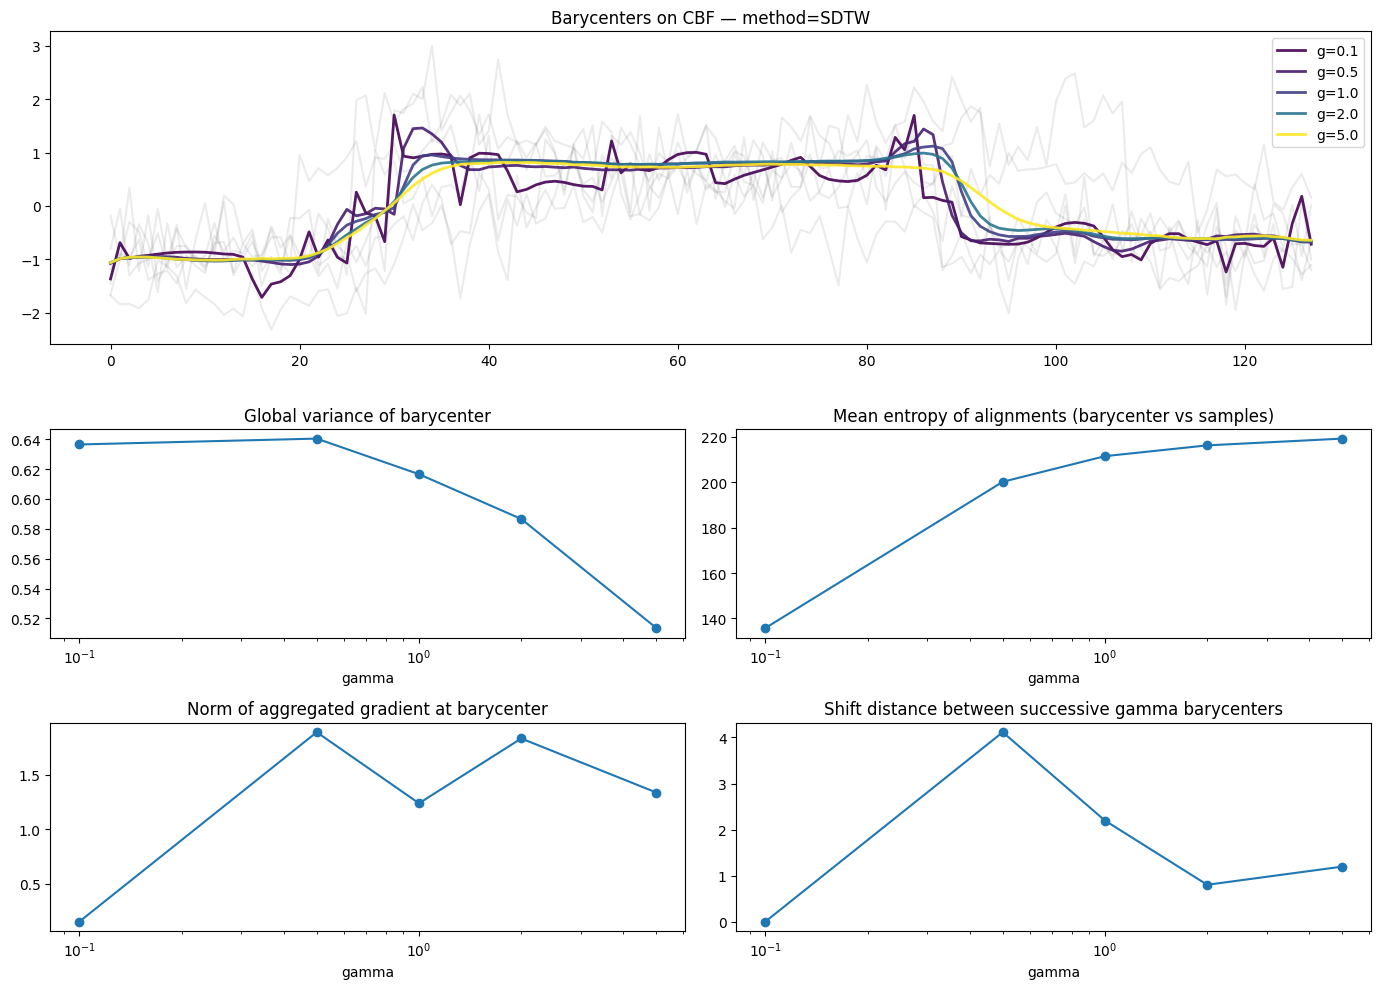

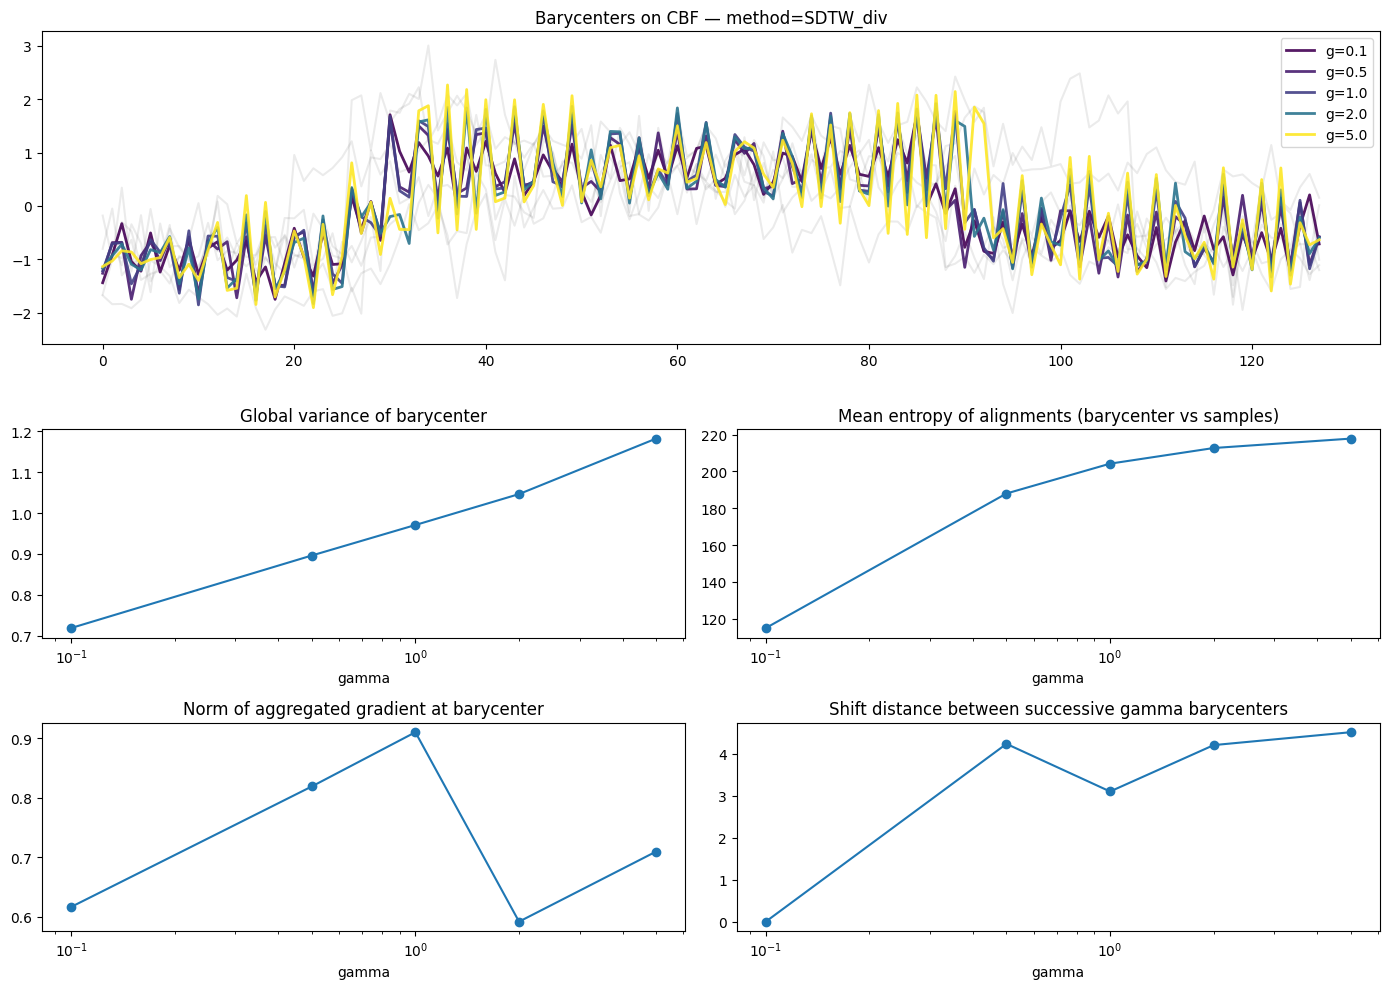

In [22]:


# Quick demo when executed as a script (small settings to keep runtime reasonable)
run_gamma_experiments('CBF', n_samples=6, gammas=[0.1, 0.5, 1.0, 2.0, 5.0], methods=('SDTW', 'SDTW_div'), out_dir='./sdtw_gamma_demo')


## Understanding the SDTW–$ \gamma $ Experiments

### 1. Motivation

Soft-DTW introduces a *smoothing parameter* $ \gamma > 0 $ that controls how “soft” the alignment is:

- Small $ \gamma \rightarrow $ alignment behaves more like **hard DTW**  
- Large $ \gamma \rightarrow $ alignment becomes more like **Euclidean averaging**

Because $ \gamma $ strongly affects optimization, alignment entropy, and the shape of barycenters, we systematically study how results change as $ \gamma $ varies.

***

### 2. Problem Setup

We are given a set of time series:

$$
\mathcal{X} = \{x^{(1)}, x^{(2)}, \dots, x^{(N)}\}, \quad
x^{(i)} \in \mathbb{R}^{T \times d}.
$$

We want to compute the **Soft-DTW barycenter**:

$$
\mu^\star_\gamma
=
\arg\min_{\mu}
\frac{1}{N}
\sum_{i=1}^N
\text{sDTW}_\gamma(\mu, x^{(i)}),
$$

and study how $ \mu^\star_\gamma $ changes as $ \gamma $ varies.

We optionally repeat the same for the **Soft-DTW divergence**:

$$
\text{sDTWDiv}_\gamma(x, y)
=
\text{sDTW}_\gamma(x, y)
- \frac{1}{2}\text{sDTW}_\gamma(x, x)
- \frac{1}{2}\text{sDTW}_\gamma(y, y).
$$

***

### 3. What We Sweep Over

We fix:

- Dataset (e.g., CBF)  
- Number of samples $ N $  
- Target barycenter length $ T $

and sweep a log-spaced range:

$$
\gamma \in \{\gamma_1, \gamma_2, \dots, \gamma_K\}.
$$

For each $ \gamma_k $, we run the barycenter optimization (with gradient descent).

---

### 4. Quantities We Measure

For each $ \gamma $, we compute several diagnostics.

#### (a) Mean Soft-DTW Cost

$$
\frac{1}{N}
\sum_{i=1}^N
\text{sDTW}_\gamma(\mu^\star_\gamma, x^{(i)}).
$$

This indicates how well the barycenter explains the data under that $ \gamma $.

***

#### (b) Barycenter Variance

We look at the variance across time points:

$$
\text{Var}(\mu^\star_\gamma) =
\frac{1}{T}
\sum_{t=1}^{T}
\left\lVert
\mu^\star_{\gamma, t} - \bar{\mu}_\gamma
\right\rVert^2,
$$

where $ \bar{\mu}_\gamma $ is the mean of the barycenter over time.  
Higher variance often corresponds to sharper, more pronounced structures.

***

#### (c) Alignment Entropy

Soft-DTW produces a *probabilistic alignment matrix* $ A_\gamma $.

We compute:

$$
H(A_\gamma)
= -\sum_{i,j}
A_\gamma(i,j)\log A_\gamma(i,j).
$$

- Low entropy → alignments are very concentrated (DTW-like)  
- High entropy → alignments distribute mass broadly (averaging-like)

***

#### (d) Gradient Norm (Optimization Stability)

We track:

$$
\left\lVert \nabla_\mu \mathcal{L}(\mu^\star_\gamma) \right\rVert_2,
$$

as a proxy for numerical stability and convergence behavior.

---

#### (e) Shift Between Neighboring Barycenters

To see how sensitive results are to $ \gamma $:

$$
\Delta(\gamma_k)
=
\left\lVert
\mu^\star_{\gamma_k} - \mu^\star_{\gamma_{k-1}}
\right\rVert_2.
$$

Large jumps indicate that $ \gamma $ materially changes the geometry.

***

### 5. What We Expect to Observe

- **Very small $ \gamma $:**
  - Sharper barycenters  
  - Low entropy  
  - Sometimes unstable gradients or noisy solutions

- **Intermediate $ \gamma $:**
  - Reasonable alignments and smooth gradients  
  - Often yield the best qualitative barycenters

- **Very large $ \gamma $:**
  - Alignments become almost uniform  
  - Barycenter approaches simple Euclidean mean  
  - High alignment entropy

Graphing these curves helps identify a *useful operating regime* for $ \gamma $.

***

### 6. Takeaways

These experiments answer:

1. **How sensitive are SDTW barycenters to $ \gamma $?**  
2. **Where is the sweet spot between rigidity and oversmoothing?**  
3. **When does SDTW effectively collapse back to Euclidean averaging?**

Together, they provide practical guidance for choosing $ \gamma $ in real applications.




# More MORe


In [23]:

from matplotlib.gridspec import GridSpec



def compute_alignment_variance(P):
    """
    Compute variance of alignment distribution.
    P: transition probability tensor of shape (size_X+2, size_Y+2, 3)
    """
    size_X, size_Y = P.shape[0] - 2, P.shape[1] - 2
    E = sdtw_grad_C(P, return_all=False)  # Expected alignment
    
    # Compute second moment (E[A^2])
    E_squared = np.sum(E ** 2)
    
    # Variance = E[A^2] - (E[A])^2
    variance = E_squared - np.sum(E) ** 2
    
    return variance, E


def analyze_gamma_effect_on_alignment(X, Y, gamma_values):
    """
    Analyze how gamma affects the alignment distribution.
    Returns metrics: entropy, variance, sparsity, max probability
    """
    C = squared_euclidean_cost(X, Y)
    
    results = {
        'gamma': [],
        'entropy': [],
        'variance': [],
        'sparsity': [],  # Fraction of near-zero probabilities
        'max_prob': [],  # Maximum probability in alignment
        'sdtw_value': [],
        'sharp_sdtw_value': []
    }
    
    for gamma in gamma_values:
        results['gamma'].append(gamma)
        
        # Compute soft-DTW and get transition probabilities
        V, P = sdtw_C(C, gamma=gamma, return_all=True)
        results['sdtw_value'].append(V[-1, -1])
        
        # Get expected alignment (gradient)
        E = sdtw_grad_C(P, return_all=False)
        
        # Compute entropy
        ent = sdtw_entropy_C(C, gamma=gamma)
        results['entropy'].append(ent)
        
        # Compute variance
        var, _ = compute_alignment_variance(P)
        results['variance'].append(var)
        
        # Compute sparsity (fraction of probabilities < 0.01)
        P_flat = P[1:-1, 1:-1, :].flatten()
        sparsity = np.mean(P_flat < 0.01)
        results['sparsity'].append(sparsity)
        
        # Maximum probability in alignment
        max_prob = np.max(E)
        results['max_prob'].append(max_prob)
        
        # Sharp SDTW value
        sharp_val = sharp_sdtw_C(C, gamma=gamma)
        results['sharp_sdtw_value'].append(sharp_val)
    
    return results


def plot_gamma_effects(results, dataset_name):
    """
    Create comprehensive visualization of gamma effects.
    """
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 3, figure=fig)
    
    gamma = results['gamma']
    
    # Plot 1: Entropy vs Gamma
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogx(gamma, results['entropy'], 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Gamma (log scale)', fontsize=12)
    ax1.set_ylabel('Entropy', fontsize=12)
    ax1.set_title('Entropy vs Gamma', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Variance vs Gamma
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.semilogx(gamma, results['variance'], 'o-', color='tab:orange', linewidth=2, markersize=8)
    ax2.set_xlabel('Gamma (log scale)', fontsize=12)
    ax2.set_ylabel('Alignment Variance', fontsize=12)
    ax2.set_title('Variance vs Gamma', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Sparsity vs Gamma
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.semilogx(gamma, results['sparsity'], 'o-', color='tab:green', linewidth=2, markersize=8)
    ax3.set_xlabel('Gamma (log scale)', fontsize=12)
    ax3.set_ylabel('Sparsity (fraction < 0.01)', fontsize=12)
    ax3.set_title('Alignment Sparsity vs Gamma', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Max Probability vs Gamma
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.semilogx(gamma, results['max_prob'], 'o-', color='tab:red', linewidth=2, markersize=8)
    ax4.set_xlabel('Gamma (log scale)', fontsize=12)
    ax4.set_ylabel('Max Alignment Probability', fontsize=12)
    ax4.set_title('Concentration vs Gamma', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: SDTW Value vs Gamma
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.semilogx(gamma, results['sdtw_value'], 'o-', color='tab:purple', linewidth=2, markersize=8)
    ax5.set_xlabel('Gamma (log scale)', fontsize=12)
    ax5.set_ylabel('Soft-DTW Value', fontsize=12)
    ax5.set_title('Soft-DTW Value vs Gamma', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Sharp SDTW vs Gamma
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.semilogx(gamma, results['sharp_sdtw_value'], 'o-', color='tab:brown', linewidth=2, markersize=8)
    ax6.set_xlabel('Gamma (log scale)', fontsize=12)
    ax6.set_ylabel('Sharp Soft-DTW Value', fontsize=12)
    ax6.set_title('Sharp Soft-DTW vs Gamma', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # Plot 7: Entropy vs Variance (relationship)
    ax7 = fig.add_subplot(gs[2, 0])
    scatter = ax7.scatter(results['entropy'], results['variance'], c=np.log10(gamma), 
                         s=100, cmap='viridis', edgecolors='black', linewidth=1)
    ax7.set_xlabel('Entropy', fontsize=12)
    ax7.set_ylabel('Variance', fontsize=12)
    ax7.set_title('Entropy-Variance Relationship', fontsize=14, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax7)
    cbar.set_label('log10(gamma)', fontsize=10)
    
    # Plot 8: Summary statistics
    ax8 = fig.add_subplot(gs[2, 1:])
    ax8.axis('off')
    
    summary_text = f"""
    GAMMA EFFECTS SUMMARY ({dataset_name})
    
    Low Gamma (γ << 1):
    • Approaches hard DTW (min-cost path)
    • Low entropy: {results['entropy'][0]:.4f}
    • Low variance: {results['variance'][0]:.4f}
    • High sparsity: {results['sparsity'][0]:.4f}
    • Alignment concentrates on single path
    
    Medium Gamma (γ ≈ 1-10):
    • Balanced soft alignment
    • Moderate exploration of paths
    • Good for most applications
    
    High Gamma (γ >> 10):
    • Diffuse alignment distribution
    • High entropy: {results['entropy'][-1]:.4f}
    • High variance: {results['variance'][-1]:.4f}
    • Low sparsity: {results['sparsity'][-1]:.4f}
    • Considers many possible paths
    
    Recommendations:
    • Use γ ∈ [0.1, 1] for near-DTW behavior
    • Use γ ∈ [1, 10] for robust averaging
    • Use γ > 10 for maximum smoothness
    """
    
    ax8.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    plt.suptitle(f'Gamma Effects Analysis on {dataset_name}', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


def visualize_alignments_for_gammas(X, Y, gamma_values, dataset_name):
    """
    Visualize expected alignments for different gamma values.
    """
    C = squared_euclidean_cost(X, Y)
    
    n_gammas = len(gamma_values)
    fig, axes = plt.subplots(2, n_gammas, figsize=(4*n_gammas, 8))
    
    for idx, gamma in enumerate(gamma_values):
        # Compute alignment
        V, P = sdtw_C(C, gamma=gamma, return_all=True)
        E = sdtw_grad_C(P, return_all=False)
        
        # Top row: Expected alignment heatmap
        ax1 = axes[0, idx] if n_gammas > 1 else axes[0]
        im = ax1.imshow(E, cmap='hot', aspect='auto', origin='lower')
        ax1.set_title(f'γ = {gamma}', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Y index')
        ax1.set_ylabel('X index')
        plt.colorbar(im, ax=ax1, fraction=0.046)
        
        # Bottom row: Alignment path visualization
        ax2 = axes[1, idx] if n_gammas > 1 else axes[1]
        ax2.imshow(C, cmap='gray_r', aspect='auto', origin='lower', alpha=0.3)
        
        # Show expected alignment as contours
        contour = ax2.contour(E, levels=10, cmap='hot', linewidths=2)
        ax2.clabel(contour, inline=True, fontsize=8)
        ax2.set_xlabel('Y index')
        ax2.set_ylabel('X index')
        ax2.set_title(f'Alignment Paths (γ={gamma})')
    
    plt.suptitle(f'Alignment Visualization: {dataset_name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


def barycenter_convergence_analysis(Ys, gamma_values, dataset_name):
    """
    Analyze how gamma affects barycenter convergence and smoothness.
    """
    fig, axes = plt.subplots(2, len(gamma_values), figsize=(5*len(gamma_values), 10))
    
    for idx, gamma in enumerate(gamma_values):
        ax1 = axes[0, idx] if len(gamma_values) > 1 else axes[0]
        ax2 = axes[1, idx] if len(gamma_values) > 1 else axes[1]
        
        # Plot input series
        for Y in Ys:
            ax1.plot(Y.ravel(), color='gray', alpha=0.3, linewidth=1)
        
        # Compute barycenter
        value_and_grad = functools.partial(sdtw_div_value_and_grad, gamma=gamma)
        X_init = euclidean_mean(Ys)
        Z = barycenter(Ys, X_init=X_init, value_and_grad=value_and_grad)
        
        # Plot barycenter
        ax1.plot(Z.ravel(), color='red', linewidth=3, label=f'Barycenter (γ={gamma})')
        ax1.set_title(f'γ = {gamma}', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Compute smoothness (second derivative)
        smoothness = np.diff(Z.ravel(), n=2)
        ax2.plot(smoothness, linewidth=2, color='blue')
        ax2.set_title(f'Smoothness (2nd derivative, γ={gamma})')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Curvature')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        
    plt.suptitle(f'Barycenter Smoothness Analysis: {dataset_name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Main experiment runner
def run_gamma_experiments(dataset_name="UWaveGestureLibraryY", n_samples=10):
    """
    Run all gamma effect experiments on a dataset.
    """
    print(f"Running Gamma Analysis on {dataset_name}...")
    
    # Load data
    X_all, y_all = load_data(dataset_name)
    
    # Select samples
    np.random.seed(42)
    indices = np.random.choice(len(X_all), n_samples, replace=False)
    Ys = [X_all[i].T for i in indices]
    
    # Take two representative samples for pairwise analysis
    X, Y = Ys[0], Ys[1]
    
    # Define gamma range (logarithmic spacing)
    gamma_values = np.logspace(-1, 2, 20)  # 0.1 to 100
    
    # Experiment 1: Analyze gamma effects on alignment properties
    print("Experiment 1: Analyzing gamma effects on alignment...")
    results = analyze_gamma_effect_on_alignment(X, Y, gamma_values)
    plot_gamma_effects(results, dataset_name)
    
    # Experiment 2: Visualize alignments for selected gammas
    print("Experiment 2: Visualizing alignments...")
    selected_gammas = [0.1, 1.0, 5.0, 20.0]
    visualize_alignments_for_gammas(X, Y, selected_gammas, dataset_name)
    
    # Experiment 3: Barycenter analysis
    print("Experiment 3: Analyzing barycenter smoothness...")
    barycenter_gammas = [0.5, 2.0, 10.0]
    barycenter_convergence_analysis(Ys[:5], barycenter_gammas, dataset_name)
    
    print("All experiments completed!")



Running Gamma Analysis on UWaveGestureLibraryY...
Experiment 1: Analyzing gamma effects on alignment...


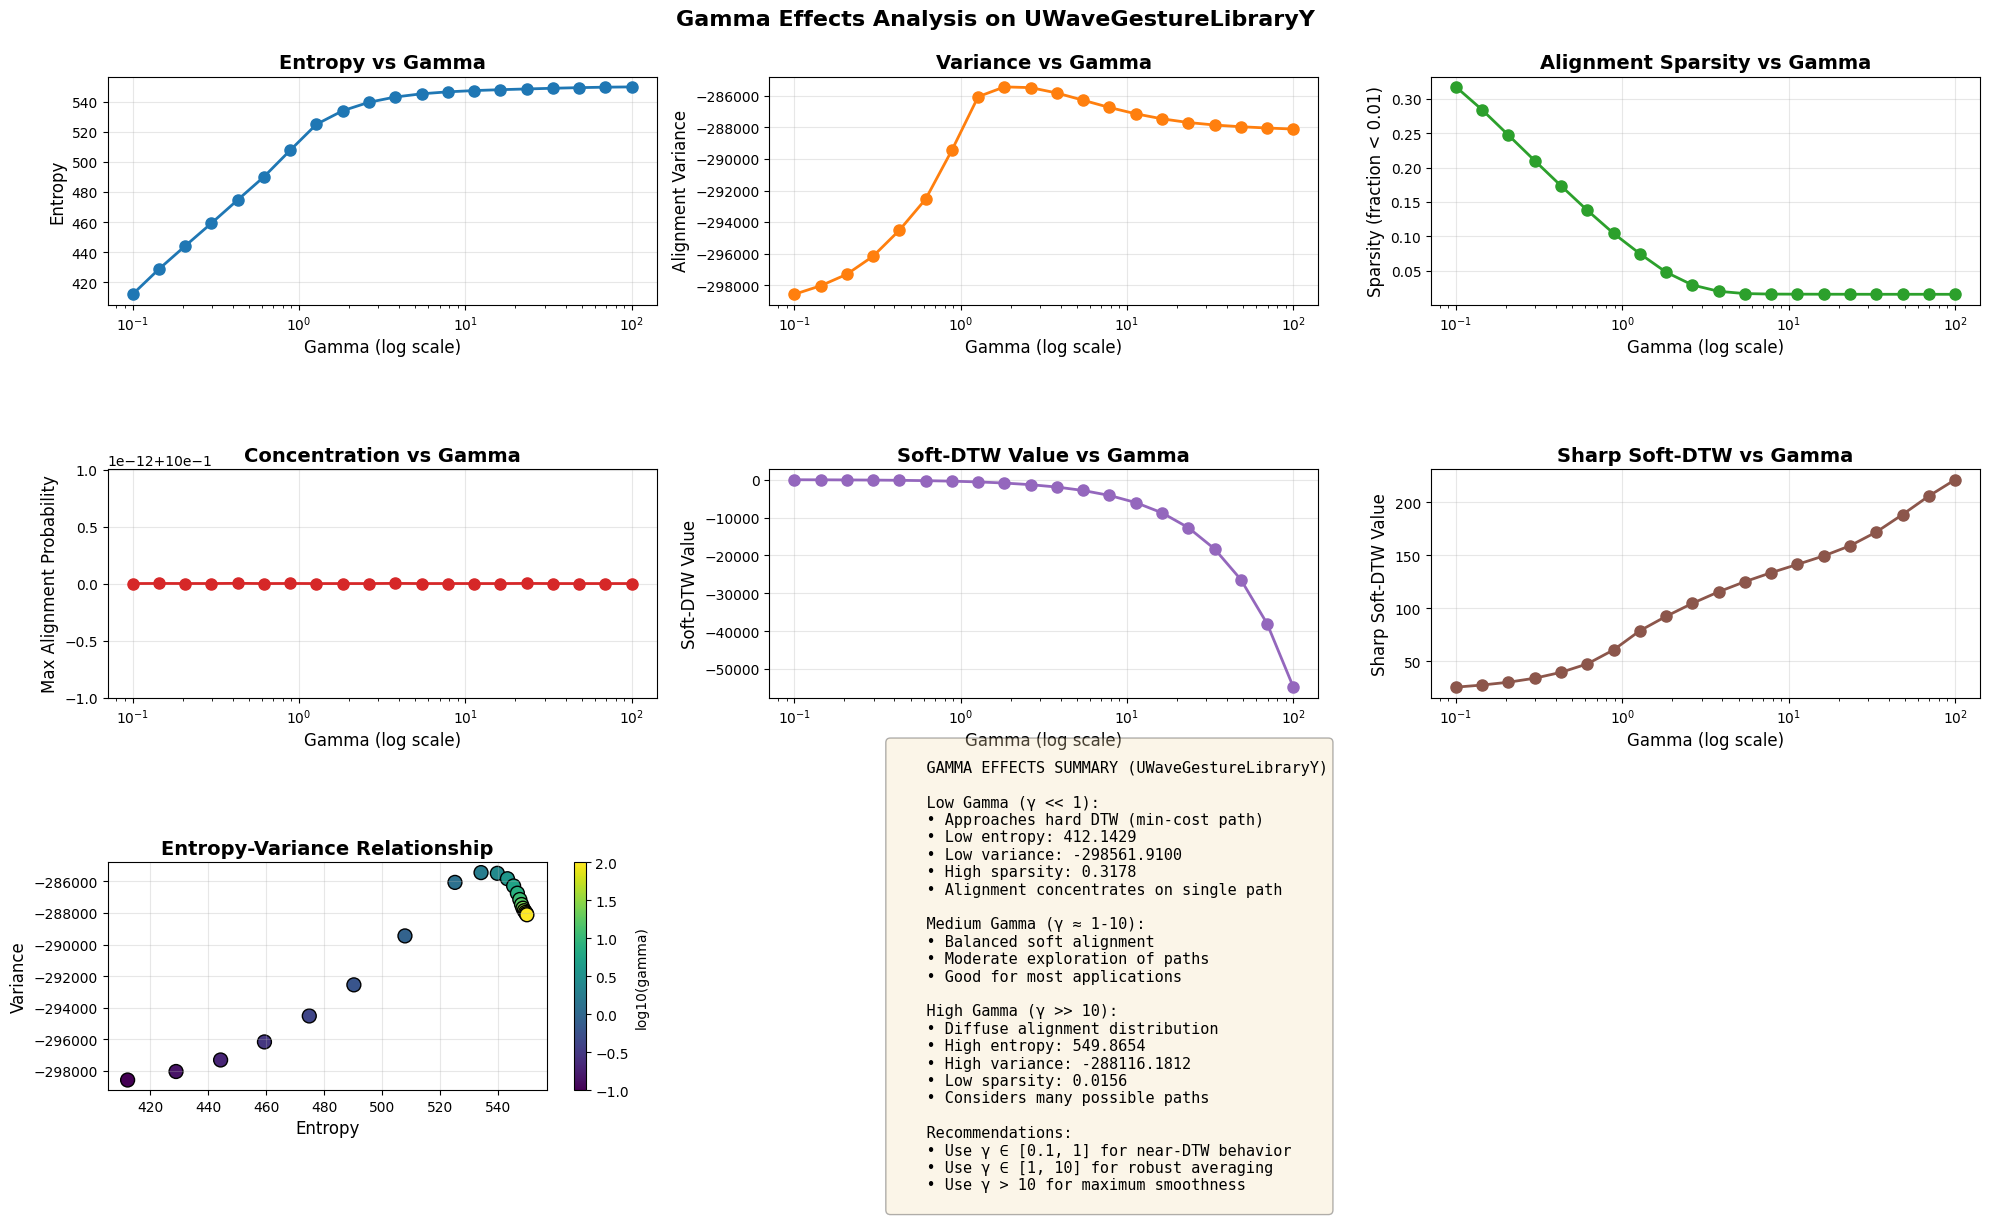

Experiment 2: Visualizing alignments...


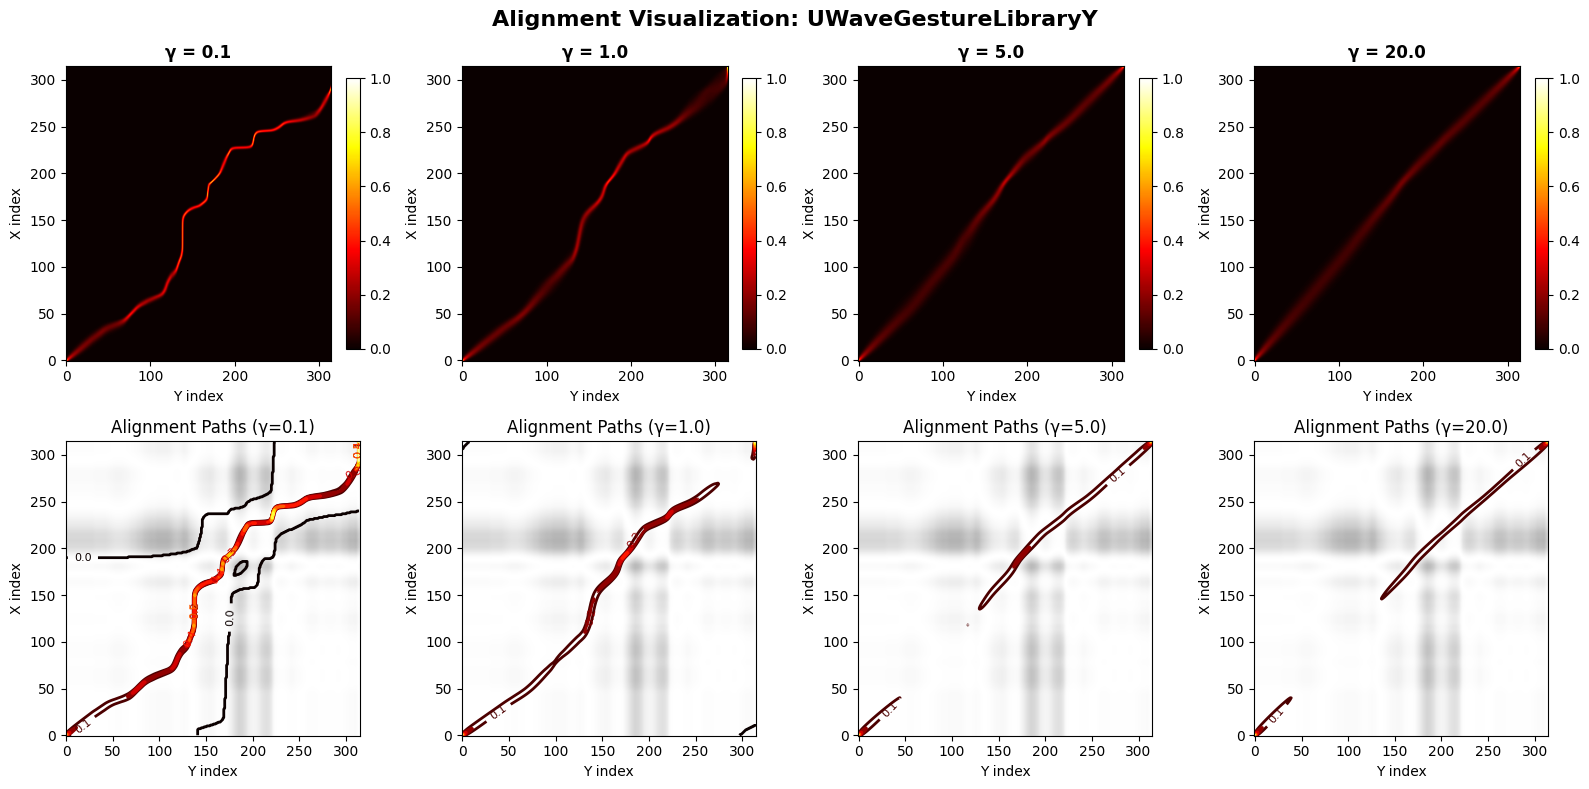

Experiment 3: Analyzing barycenter smoothness...


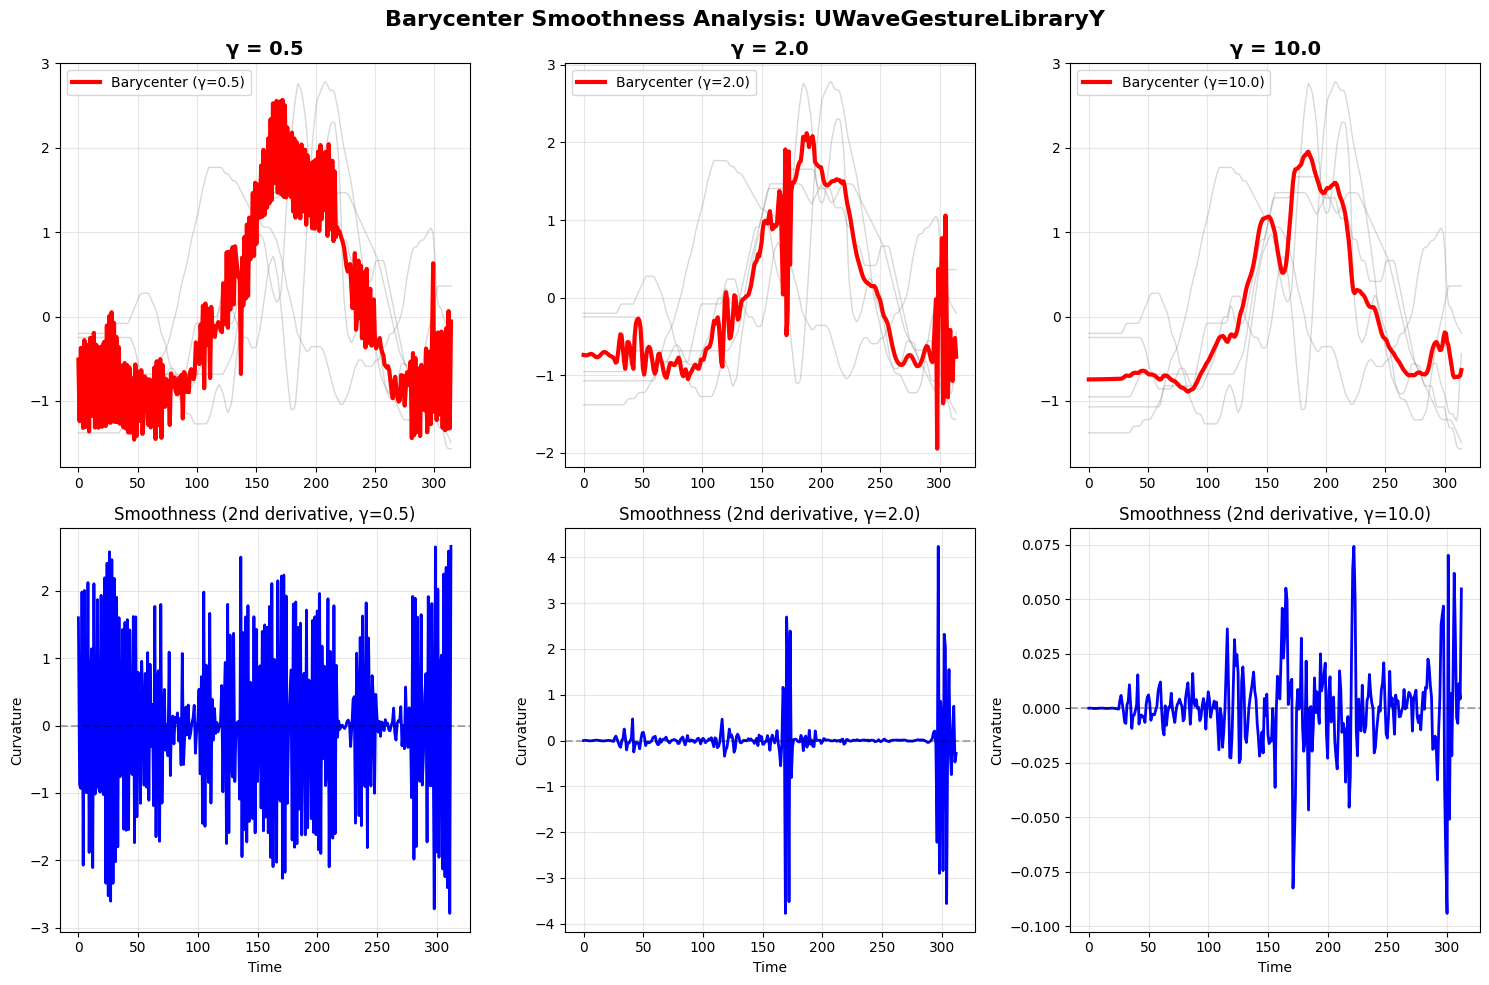

All experiments completed!
Running Gamma Analysis on ArrowHead...
Experiment 1: Analyzing gamma effects on alignment...


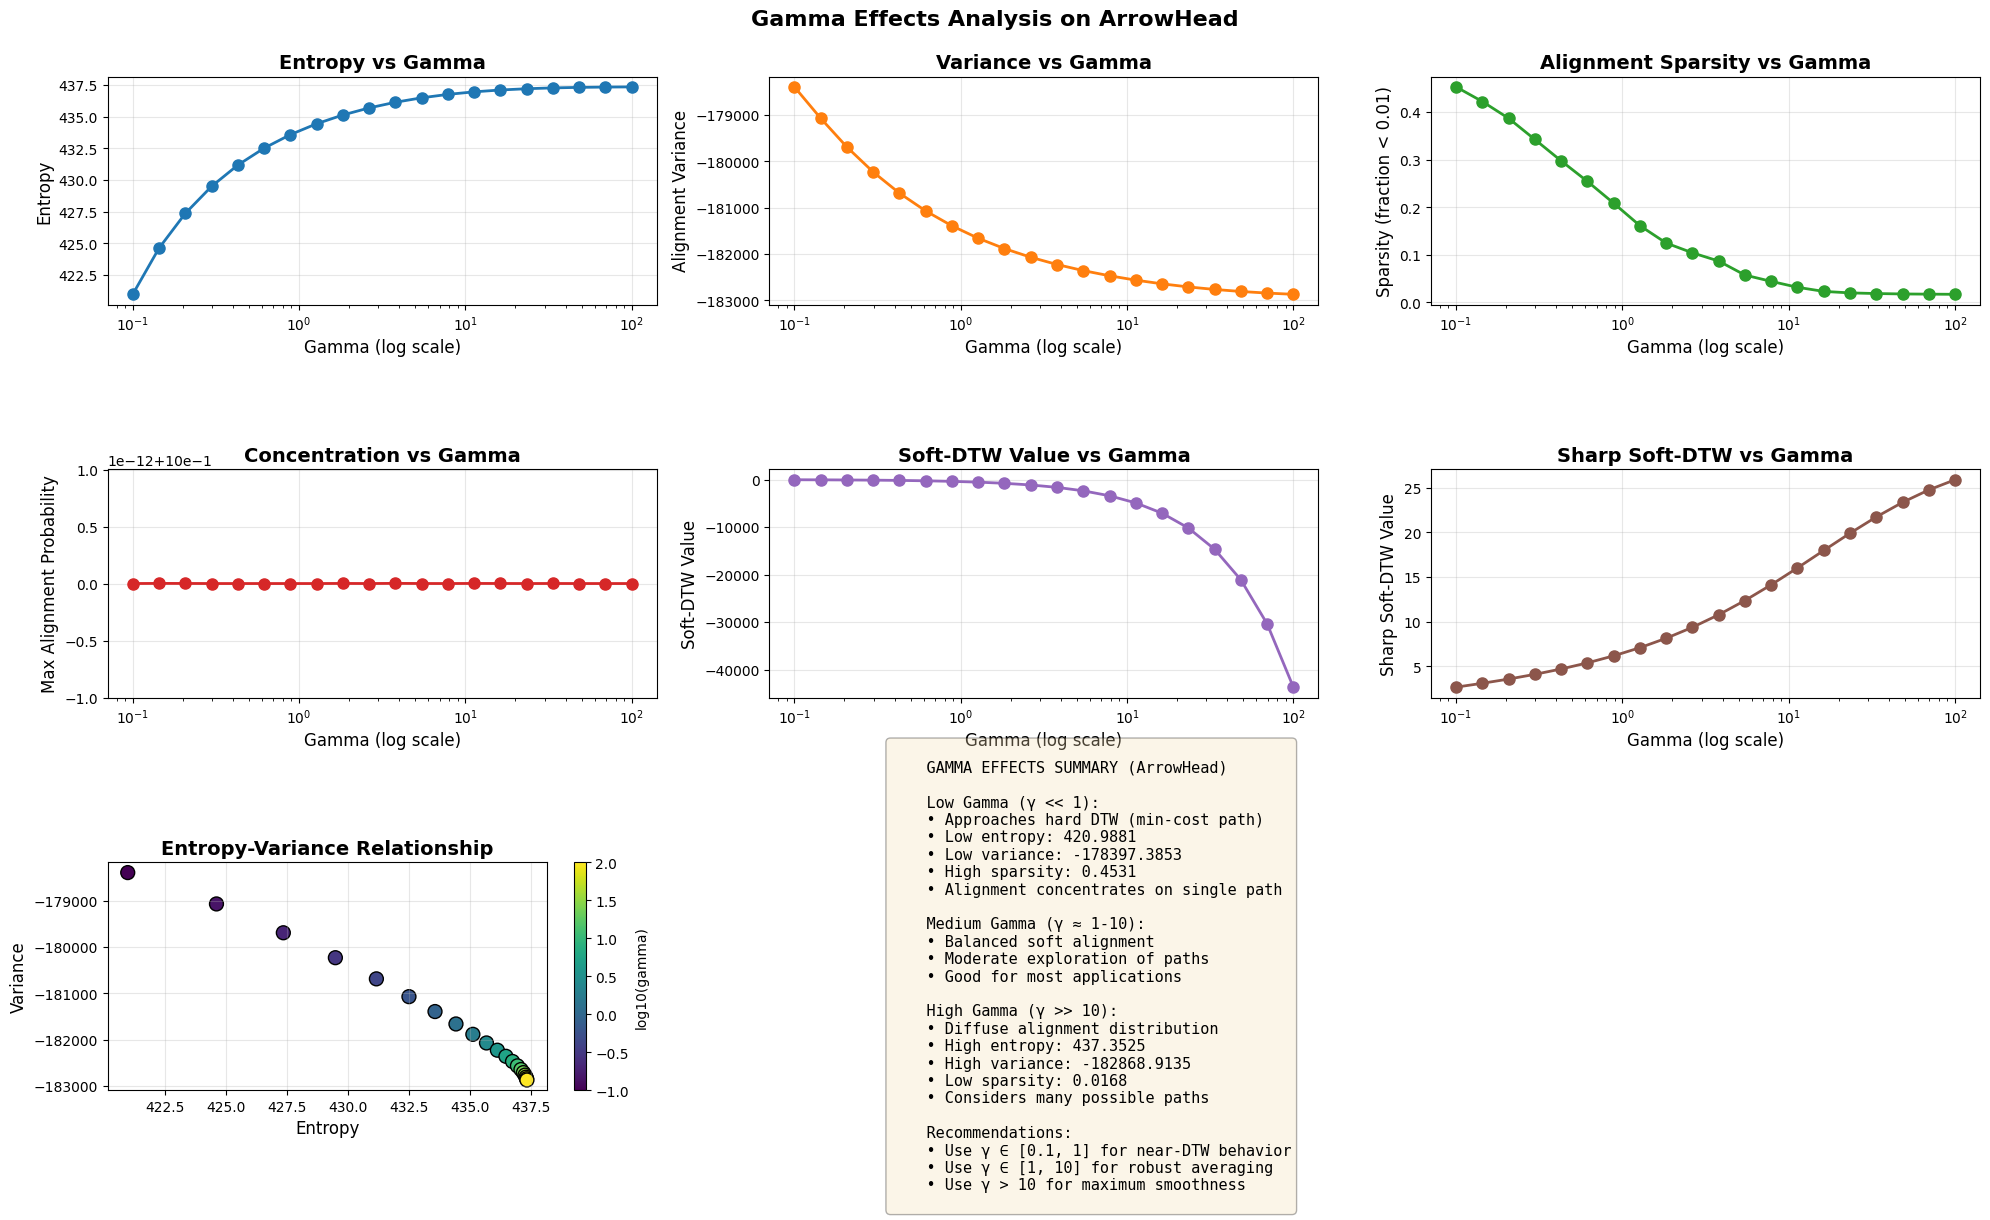

Experiment 2: Visualizing alignments...


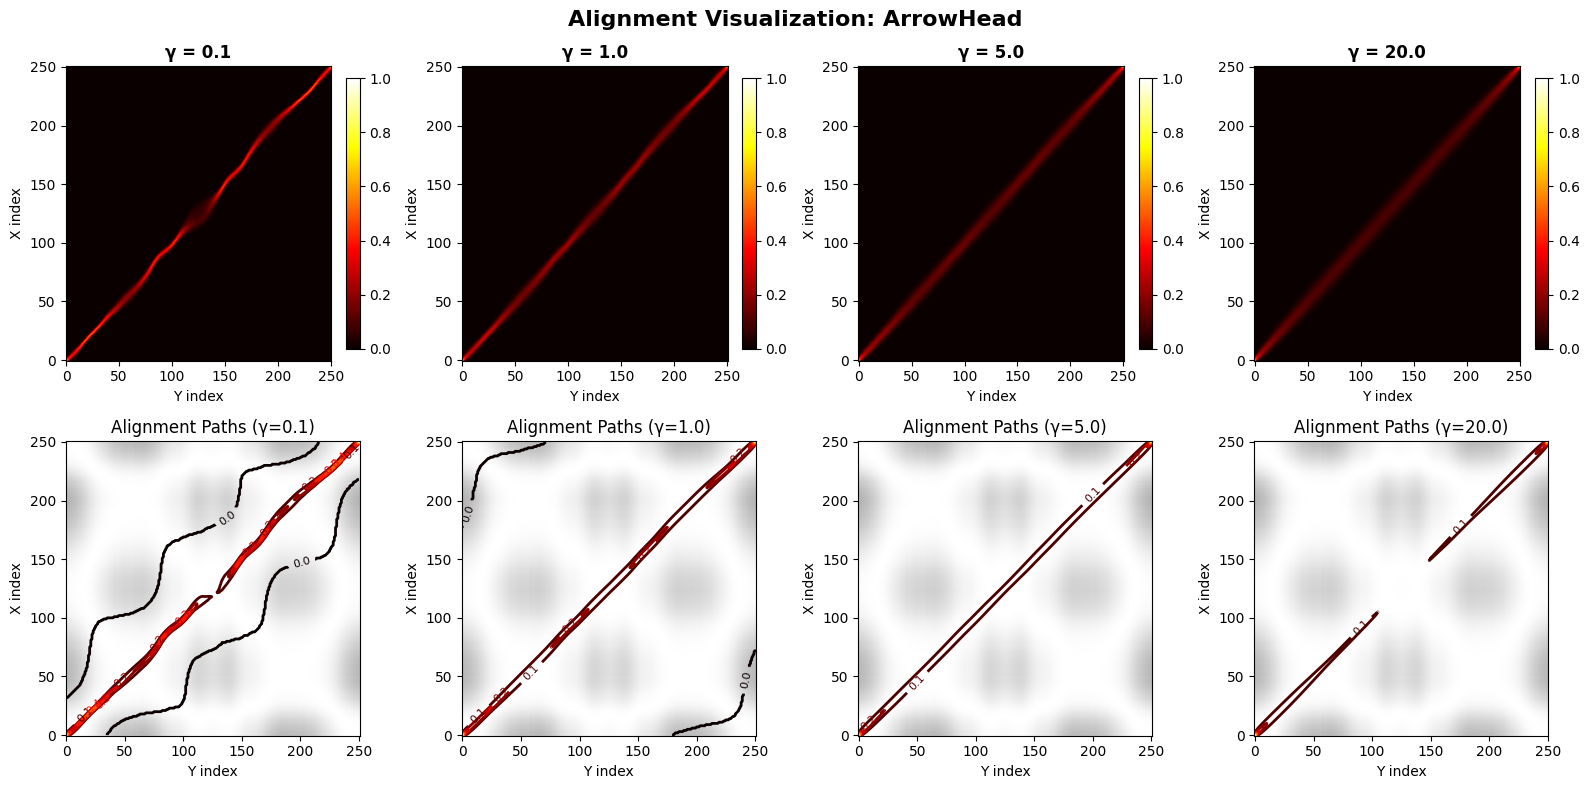

Experiment 3: Analyzing barycenter smoothness...


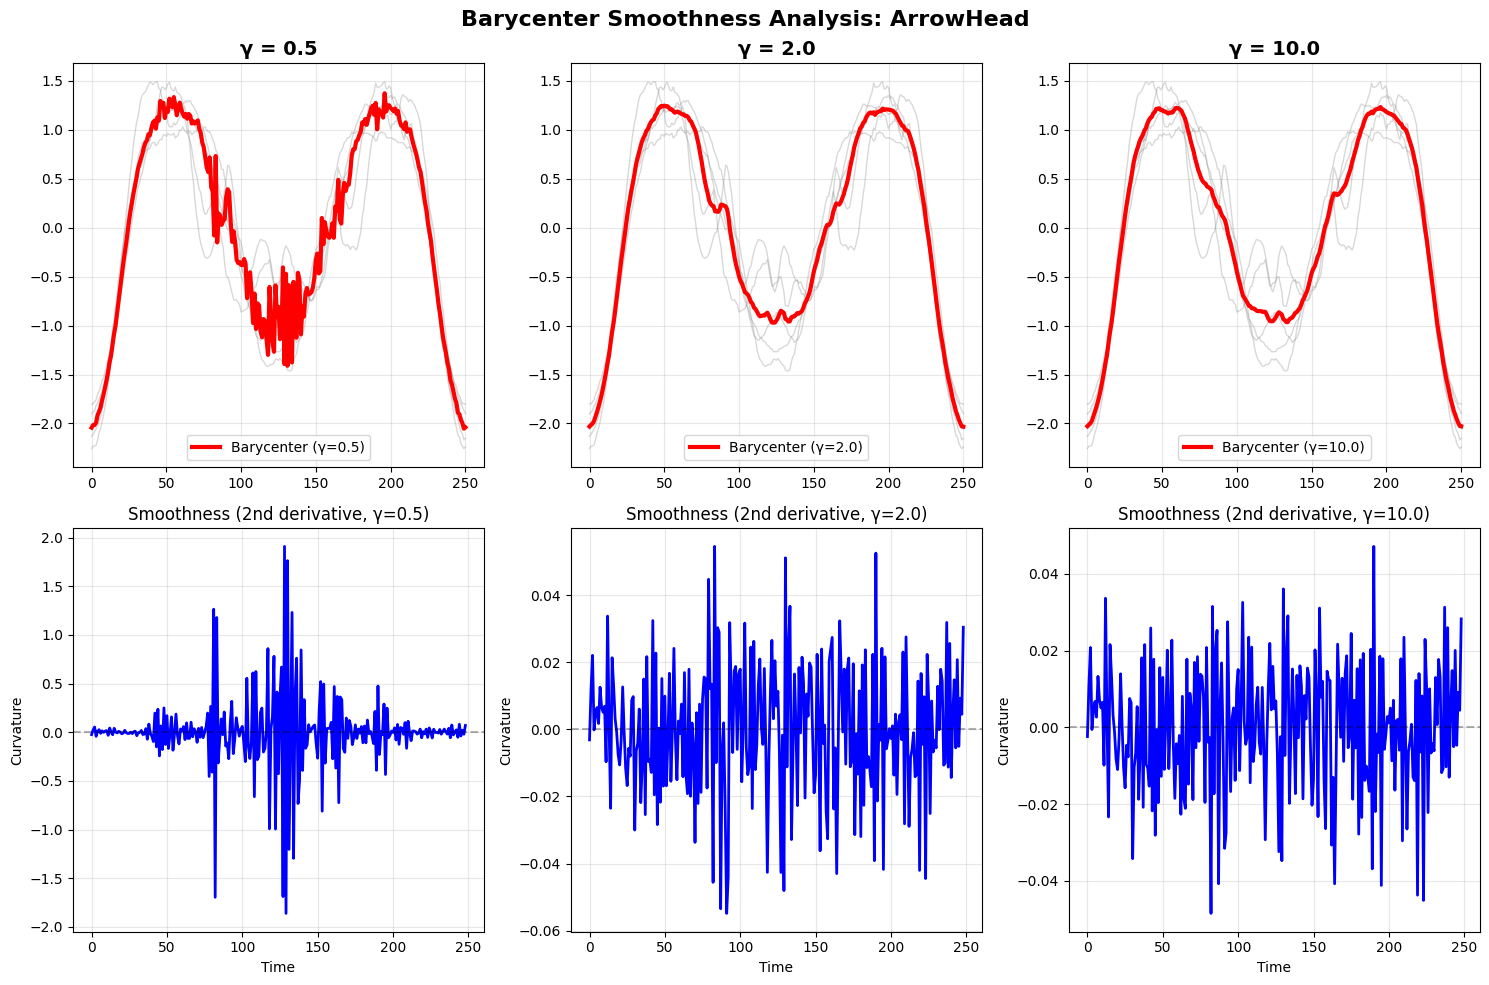

All experiments completed!


In [27]:


run_gamma_experiments("UWaveGestureLibraryY", n_samples=10)
run_gamma_experiments("ArrowHead", n_samples=10)
# run_gamma_experiments("CBF", n_samples=10)

# More ++

In [ ]:
"""
sdtw_gamma_experiments.py

Extended experiments module for soft-DTW / divergences.

This file augments the original `sdtw_gamma_experiments.py` with four concrete
experiments requested:

- Downstream task: clustering and classification using barycenters as prototypes.
- Sensitivity to initialization: run barycenter with several inits and summarize.
- Robustness to noise: inject noise types and compare methods.
- Gamma annealing: warm-start vs cold-start across a gamma schedule.

The script expects the SDTW functions from your original implementation to be
importable in the current Python path (module `sdtw_div` or available in the
namespace). Key functions used: `barycenter`, `euclidean_mean`, `sdtw`,
`sdtw_div_value_and_grad`, `sdtw_value_and_grad`, and `squared_euclidean_cost`.

"""



barycenter = globals().get('barycenter')
euclidean_mean = globals().get('euclidean_mean')
sdtw = globals().get('sdtw')
sdtw_div_value_and_grad = globals().get('sdtw_div_value_and_grad')
sdtw_value_and_grad = globals().get('sdtw_value_and_grad')
sharp_sdtw_value_and_grad = globals().get('sharp_sdtw_value_and_grad')
load_data = globals().get('load_data')


try:
    from sklearn.cluster import KMeans
    from sklearn.metrics import normalized_mutual_info_score, accuracy_score
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False


def as_time_dim(x):
    x = np.asarray(x)

    # 1D -> (T,1)
    if x.ndim == 1:
        return x.reshape(-1, 1)

    # (1, T) -> (T, 1)
    if x.shape[0] == 1 and x.shape[1] > 1:
        return x.T

    return x


# ------------------------- Utilities -------------------------

def _ensure_list_of_Ys(X_all, indices):
    Ys = []
    for i in indices:
        x = X_all[i]
        arr = np.asarray(x)
        if arr.ndim == 1:
            arr = arr[:, np.newaxis]
        if arr.shape[0] == 1 and arr.shape[1] > 1:
            arr = arr.T
        Ys.append(arr)
    return Ys


def _save_fig(fig, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path, dpi=150)
    plt.close(fig)


# ---------------- Downstream task ----------------

def run_downstream_task(dataset_name,
                        n_train=100,
                        n_test=100,
                        n_prototypes_per_class=1,
                        gamma=1.0,
                        method='SDTW_div',
                        out_dir='./downstream_results'):
    """Prototype-based classification and clustering using barycenters.

    - For classification: compute per-class barycenters (prototypes) on training
      set and classify test samples by nearest soft-DTW distance to prototypes.
    - For clustering: run KMeans on flattened time series, or initialize KMeans
      with barycenters (if sklearn available).

    Returns dict with accuracy / NMI and saved plots.
    """

    os.makedirs(out_dir, exist_ok=True)
    X_all, y_all = load_data(dataset_name)
    if X_all is None:
        raise RuntimeError('Could not load dataset')

    # Simple train/test split (first N for training, next N for test)
    n_total = len(X_all)
    n_train = min(n_train, n_total // 2)
    n_test = min(n_test, n_total - n_train)

    X_train = X_all[:n_train]
    y_train = y_all[:n_train]
    X_test = X_all[n_train:n_train + n_test]
    y_test = y_all[n_train:n_train + n_test]

    classes = np.unique(y_train)

    # Compute prototypes (barycenters) per class
    prototypes = {}
    for c in classes:
        idx = [i for i, yy in enumerate(y_train) if yy == c]
        if len(idx) == 0:
            continue
        # Limit number of series used per-class if many
        Ys = _ensure_list_of_Ys(X_train, idx[:50])
        init = euclidean_mean(Ys)
        if method == 'SDTW_div':
            vg = functools.partial(sdtw_div_value_and_grad, gamma=gamma)
        else:
            vg = functools.partial(sdtw_value_and_grad, gamma=gamma)
        proto = barycenter(Ys, X_init=init, value_and_grad=vg)
        prototypes[c] = proto

    # Classification by nearest prototype under sdtw distance
    preds = []
    for x in X_test:
        x_arr = np.asarray(x)
        x_arr = as_time_dim(x_arr)
        if x_arr.ndim == 1:
            x_arr = x_arr[:, np.newaxis]
        best_c = None
        best_d = float('inf')
        for c, proto in prototypes.items():
            try:
                proto = as_time_dim(proto)
                d = float(sdtw(proto, x_arr, gamma=gamma))
            except Exception:
                d = float(sdtw(proto, x_arr))
            if d < best_d:
                best_d = d
                best_c = c
        preds.append(best_c)

    acc = float(np.mean(np.array(preds) == np.array(y_test))) if len(preds) > 0 else np.nan

    results = dict(accuracy=acc, n_train=n_train, n_test=n_test)

    # Optional clustering experiment using sklearn KMeans
    if SKLEARN_AVAILABLE:
        # Prepare flattened representations (simple baseline)
        X_flat = np.array([np.asarray(x).ravel() for x in X_train])
        k = len(classes)
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X_flat)
        labels = kmeans.predict(np.array([np.asarray(x).ravel() for x in X_test]))
        nmi = normalized_mutual_info_score(y_test, labels)
        results['kmeans_nmi'] = float(nmi)

        # Try initializing KMeans with barycenters (flattened)
        prototypes_flat = np.array([prototypes[c].ravel() for c in classes])
        if prototypes_flat.shape[1] == X_flat.shape[1]:
            kmeans_init = KMeans(n_clusters=k, init=prototypes_flat, n_init=1, random_state=42).fit(X_flat)
            labels_init = kmeans_init.predict(np.array([np.asarray(x).ravel() for x in X_test]))
            nmi_init = normalized_mutual_info_score(y_test, labels_init)
            results['kmeans_nmi_init'] = float(nmi_init)

    # Save a quick plot of prototypes
    fig, ax = plt.subplots(figsize=(8, 4))
    for c, proto in prototypes.items():
        ax.plot(proto.ravel(), label=f'class {c}')
    ax.set_title(f'Prototypes for {dataset_name} (method={method}, gamma={gamma})')
    ax.legend()
    _save_fig(fig, os.path.join(out_dir, f'prototypes_{dataset_name}.png'))

    results['preds'] = preds
    results['y_test'] = list(y_test)
    print('Downstream task results:', results)
    return results


# ---------------- Sensitivity to initialization ----------------

def sensitivity_initialization_experiment(dataset_name,
                                          n_samples=8,
                                          gamma=1.0,
                                          inits=('euclidean', 'random', 'one_sample', 'noisy'),
                                          out_dir='./sensitivity_init_results'):
    """Run barycenter with different initializations and summarize.

    Produces:
      - histogram / violin of final-objective values
      - distance matrix between final solutions
    """
    os.makedirs(out_dir, exist_ok=True)
    X_all, y_all = load_data(dataset_name)
    indices = np.random.RandomState(123).choice(len(X_all), size=min(n_samples, len(X_all)), replace=False)
    Ys = _ensure_list_of_Ys(X_all, indices)

    # Prepare inits
    solutions = {}
    objectives = {}

    for init_name in inits:
        if init_name == 'euclidean':
            X0 = euclidean_mean(Ys)
        elif init_name == 'random':
            # Random noise sequence with same shape as Euclidean mean
            ref = euclidean_mean(Ys)
            X0 = ref + np.random.RandomState(42).normal(scale=0.5 * np.std(ref), size=ref.shape)
        elif init_name == 'one_sample':
            X0 = Ys[0].copy()
        elif init_name == 'noisy':
            ref = euclidean_mean(Ys)
            X0 = ref + np.random.RandomState(7).normal(scale=0.2 * np.std(ref), size=ref.shape)
        else:
            raise ValueError('Unknown init: ' + init_name)

        print('Running barycenter init=', init_name)
        vg = functools.partial(sdtw_value_and_grad, gamma=gamma)
        Z = barycenter(Ys, X_init=X0, value_and_grad=vg)
        solutions[init_name] = Z
        # compute objective
        obj = 0.0
        for Y in Ys:
            obj += float(sdtw(Z, Y, gamma=gamma))
        objectives[init_name] = obj / len(Ys)

    # Distance matrix
    keys = list(solutions.keys())
    K = len(keys)
    D = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            D[i, j] = np.linalg.norm(solutions[keys[i]].ravel() - solutions[keys[j]].ravel())

    # Plot objective bar and heatmap
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(range(K), [objectives[k] for k in keys])
    axes[0].set_xticks(range(K)); axes[0].set_xticklabels(keys)
    axes[0].set_title('Final mean objective')

    im = axes[1].imshow(D, interpolation='nearest')
    axes[1].set_xticks(range(K)); axes[1].set_xticklabels(keys)
    axes[1].set_yticks(range(K)); axes[1].set_yticklabels(keys)
    axes[1].set_title('Pairwise distances between solutions')
    fig.colorbar(im, ax=axes[1])
    _save_fig(fig, os.path.join(out_dir, f'sensitivity_{dataset_name}.png'))

    print('Objectives:', objectives)
    return solutions, objectives, D


# ---------------- Robustness to noise ----------------

def _add_gaussian_noise(Y, sigma):
    return Y + np.random.normal(scale=sigma, size=Y.shape)


def _add_spikes(Y, n_spikes, mag=3.0):
    Y2 = Y.copy()
    T = Y2.shape[0]
    for _ in range(n_spikes):
        t = np.random.randint(0, T)
        Y2[t] += mag * (np.random.randn(Y.shape[1]) if Y.ndim == 2 else mag * np.random.randn())
    return Y2


def robustness_to_noise_experiment(dataset_name,
                                   n_samples=8,
                                   gamma=1.0,
                                   noise_levels=(0.1, 0.5, 1.0, 2.0),
                                   out_dir='./robustness_noise_results'):
    """Compare barycenters computed with different methods under noise.

    Methods compared: SDTW (biased), SDTW divergence (unbiased), Sharp-SDTW.
    """
    os.makedirs(out_dir, exist_ok=True)
    X_all, y_all = load_data(dataset_name)
    indices = np.random.RandomState(10).choice(len(X_all), size=min(n_samples, len(X_all)), replace=False)
    Ys_clean = _ensure_list_of_Ys(X_all, indices)

    methods = ['SDTW', 'SDTW_div', 'Sharp']
    results = {m: [] for m in methods}

    for sigma in noise_levels:
        print('Noise level sigma=', sigma)
        Ys_noisy = [ _add_gaussian_noise(Y, sigma) for Y in Ys_clean ]

        # Compute barycenters for each method
        for m in methods:
            if m == 'SDTW':
                vg = functools.partial(sdtw_value_and_grad, gamma=gamma)
                init = euclidean_mean(Ys_noisy)
                Z = barycenter(Ys_noisy, X_init=init, value_and_grad=vg)
            elif m == 'SDTW_div':
                vg = functools.partial(sdtw_div_value_and_grad, gamma=gamma)
                init = euclidean_mean(Ys_noisy)
                Z = barycenter(Ys_noisy, X_init=init, value_and_grad=vg)
            elif m == 'Sharp':
                vg = functools.partial(sharp_sdtw_value_and_grad, gamma=gamma)
                init = euclidean_mean(Ys_noisy)
                Z = barycenter(Ys_noisy, X_init=init, value_and_grad=vg)
            else:
                continue

            # Evaluate reconstruction vs clean average
            recon_err = np.mean([sdtw(Z, Yc, gamma=gamma) for Yc in Ys_clean])
            results[m].append(float(recon_err))

            # Save the barycenter plot for visual check
            fig, ax = plt.subplots(figsize=(6, 3))
            for Y in Ys_noisy:
                ax.plot(Y.ravel(), color='k', alpha=0.08)
            ax.plot(Z.ravel(), linewidth=2, label=f'{m} sigma={sigma}')
            ax.legend()
            _save_fig(fig, os.path.join(out_dir, f'bary_{m}_sigma{sigma}.png'))

    # Plot result curves
    fig, ax = plt.subplots(figsize=(6, 4))
    for m in methods:
        ax.plot(noise_levels, results[m], marker='o', label=m)
    ax.set_xlabel('noise sigma'); ax.set_ylabel('mean sDTW to clean'); ax.set_title('Robustness to Gaussian noise')
    ax.legend(); ax.set_xscale('linear')
    _save_fig(fig, os.path.join(out_dir, f'robustness_summary_{dataset_name}.png'))

    print('Robustness results saved to', out_dir)
    return results


# ---------------- Gamma annealing ----------------

def gamma_annealing_experiment(dataset_name,
                               n_samples=8,
                               gammas=(10.0, 5.0, 2.0, 1.0, 0.5, 0.1),
                               method='SDTW',
                               out_dir='./gamma_annealing_results'):
    """Compare warm-start vs cold-start when sweeping gamma.

    - Warm-start: start from a large gamma and use its barycenter as init for the next
      (smaller) gamma.
    - Cold-start: re-run barycenter from Euclidean mean for each gamma independently.

    Saves plots of barycenters and metrics (objective, shift distance, gradient norm).
    """
    os.makedirs(out_dir, exist_ok=True)
    X_all, y_all = load_data(dataset_name)
    indices = np.random.RandomState(0).choice(len(X_all), size=min(n_samples, len(X_all)), replace=False)
    Ys = _ensure_list_of_Ys(X_all, indices)

    # Helper to get vg
    def _vg_for(meth, g):
        if meth == 'SDTW':
            return functools.partial(sdtw_value_and_grad, gamma=g)
        if meth == 'SDTW_div':
            return functools.partial(sdtw_div_value_and_grad, gamma=g)
        if meth == 'Sharp':
            return functools.partial(sharp_sdtw_value_and_grad, gamma=g)
        raise ValueError('Unknown method')

    # Cold-start
    cold_results = {}
    print('Running cold-start schedule...')
    for g in gammas:
        print(' gamma=', g)
        init = euclidean_mean(Ys)
        vg = _vg_for(method, g)
        Z = barycenter(Ys, X_init=init, value_and_grad=vg)
        cold_results[g] = Z

    # Warm-start (descending gammas: large->small)
    warm_results = {}
    print('Running warm-start schedule...')
    prev = None
    for g in gammas:
        print(' gamma=', g)
        vg = _vg_for(method, g)
        if prev is None:
            init = euclidean_mean(Ys)
        else:
            init = prev
        Z = barycenter(Ys, X_init=init, value_and_grad=vg)
        warm_results[g] = Z
        prev = Z

    # Compute metrics (objective and shift)
    def _metrics(results_dict):
        objs = []
        shifts = []
        prevz = None
        for g in gammas:
            Z = results_dict[g]
            objs.append(np.mean([sdtw(Z, Y, gamma=g) for Y in Ys]))
            if prevz is None:
                shifts.append(0.0)
            else:
                shifts.append(np.linalg.norm(Z.ravel() - prevz.ravel()))
            prevz = Z
        return np.array(objs), np.array(shifts)

    cold_objs, cold_shifts = _metrics(cold_results)
    warm_objs, warm_shifts = _metrics(warm_results)

    # Plot representative barycenters
    fig, ax = plt.subplots(figsize=(8, 4))
    for g in gammas:
        ax.plot(cold_results[g].ravel(), alpha=0.6, linestyle='--', label=f'cold g={g}')
        ax.plot(warm_results[g].ravel(), alpha=0.6, label=f'warm g={g}')
    ax.set_title(f'Cold vs Warm barycenters ({dataset_name})')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    _save_fig(fig, os.path.join(out_dir, f'bary_warm_cold_{dataset_name}.png'))

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(gammas, cold_objs, marker='o', linestyle='--', label='cold')
    axes[0].plot(gammas, warm_objs, marker='o', label='warm')
    axes[0].set_xscale('log')
    axes[0].set_title('Mean sDTW objective vs gamma')
    axes[0].invert_xaxis()

    axes[1].plot(gammas, cold_shifts, marker='o', linestyle='--', label='cold')
    axes[1].plot(gammas, warm_shifts, marker='o', label='warm')
    axes[1].set_xscale('log')
    axes[1].set_title('Shift between successive gammas')
    axes[1].invert_xaxis()

    axes[0].legend(); axes[1].legend()
    _save_fig(fig, os.path.join(out_dir, f'metrics_warm_cold_{dataset_name}.png'))

    print('Gamma annealing experiment saved to', out_dir)
    return dict(cold=cold_results, warm=warm_results,
                cold_objs=cold_objs, warm_objs=warm_objs,
                cold_shifts=cold_shifts, warm_shifts=warm_shifts)





In [33]:

run_downstream_task('CBF', n_train=40, n_test=40, gamma=2.0, out_dir='./demo_downstream')


UnboundLocalError: local variable 'x_arr' referenced before assignment

In [30]:
sensitivity_initialization_experiment('CBF', n_samples=6, gamma=2.0, out_dir='./demo_sensitivity')


Running barycenter init= euclidean
Running barycenter init= random
Running barycenter init= one_sample
Running barycenter init= noisy
Objectives: {'euclidean': -396.7188362117757, 'random': -396.8100525173914, 'one_sample': -396.1000370857539, 'noisy': -396.6899237424782}


({'euclidean': array([[-0.55258091],
         [-0.62903663],
         [-0.70029418],
         [-0.75892207],
         [-0.78160505],
         [-0.8021646 ],
         [-0.78618474],
         [-0.79779765],
         [-0.77160226],
         [-0.7638855 ],
         [-0.7495915 ],
         [-0.73498385],
         [-0.71428982],
         [-0.70259504],
         [-0.67599955],
         [-0.67787325],
         [-0.67003731],
         [-0.65956833],
         [-0.64302175],
         [-0.61965593],
         [-0.59639816],
         [-0.55545983],
         [-0.51014634],
         [-0.45275646],
         [-0.39285589],
         [-0.31318005],
         [-0.20295566],
         [-0.04588212],
         [ 0.18602828],
         [ 0.45643105],
         [ 0.68307414],
         [ 0.82187764],
         [ 0.89578113],
         [ 0.93872004],
         [ 0.97019234],
         [ 0.99685979],
         [ 1.02506466],
         [ 1.05351268],
         [ 1.07687533],
         [ 1.09885872],
         [ 1.11228526],
   

In [31]:
robustness_to_noise_experiment('CBF', n_samples=6, gamma=2.0, out_dir='./demo_robustness')
gamma_annealing_experiment('CBF', n_samples=6, gammas=(5.0, 2.0, 1.0, 0.5, 0.1), method='SDTW', out_dir='./demo_anneal')

Noise level sigma= 0.1
Noise level sigma= 0.5
Noise level sigma= 1.0
Noise level sigma= 2.0
Robustness results saved to ./demo_robustness
Running cold-start schedule...
 gamma= 5.0
 gamma= 2.0
 gamma= 1.0
 gamma= 0.5
 gamma= 0.1
Running warm-start schedule...
 gamma= 5.0
 gamma= 2.0
 gamma= 1.0
 gamma= 0.5
 gamma= 0.1
Gamma annealing experiment saved to ./demo_anneal


{'cold': {5.0: array([[-0.60280407],
         [-0.72996276],
         [-0.81629196],
         [-0.84746905],
         [-0.83273703],
         [-0.82060658],
         [-0.7803002 ],
         [-0.73576422],
         [-0.71619327],
         [-0.67919236],
         [-0.67604063],
         [-0.65906574],
         [-0.64692225],
         [-0.63274547],
         [-0.62220393],
         [-0.61383938],
         [-0.61479824],
         [-0.59376051],
         [-0.59066757],
         [-0.58849207],
         [-0.57337061],
         [-0.55393183],
         [-0.52632785],
         [-0.50739082],
         [-0.46692688],
         [-0.41158795],
         [-0.34716412],
         [-0.24564029],
         [-0.13916346],
         [-0.01294505],
         [ 0.1428107 ],
         [ 0.32332807],
         [ 0.50299054],
         [ 0.65958097],
         [ 0.77831448],
         [ 0.88284186],
         [ 0.9523693 ],
         [ 1.01242575],
         [ 1.03947704],
         [ 1.05543412],
         [ 1.05435179],
   